In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h[2]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
# del cm_target[1,2,3,4,7,8,10,11,13,14]
del cm_target[14]
del cm_target[13]
del cm_target[11]
del cm_target[10]
del cm_target[8]
del cm_target[7]
del cm_target[1:5]
del cm_target[0]

In [11]:
cm_target

['case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case15cm_blade1.csv',
 'case18cm_blade1.csv',
 'case21cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (25000, 2)
Dimension - heights of Gurney flaps:  (25000, 1)
Dimension - inclination(beta):  (25000, 1)
Dimension - x:  (25000, 3)
Dimension - y:  (25000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221229\\5h"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_5h_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-06,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-6, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
13/17 [=====================>........] - ETA: 0s - loss: 0.0724 - rmse: 0.2689 
Epoch 1: val_loss improved from inf to 0.06277, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 1s 20ms/step - loss: 0.0705 - rmse: 0.2652 - val_loss: 0.0628 - val_rmse: 0.2503 - lr: 1.0000e-04
Epoch 2/10000
12/17 [====================>.........] - ETA: 0s - loss: 0.0625 - rmse: 0.2497
Epoch 2: val_loss improved from 0.06277 to 0.06139, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0619 - rmse: 0.2485 - val_loss: 0.0614 - val_rmse: 0.2476 - lr: 1.0000e-04
Epoch 3/10000
12/17 [====================>.........] - ETA: 0s - loss: 0.0598 - rmse: 0.2444
Epoch 3: val_loss improved from 0.06139 to 0.06088, saving model to D:\TrainedModels\2022122

17/17 [==============================] - 0s 11ms/step - loss: 0.0595 - rmse: 0.2437 - val_loss: 0.0597 - val_rmse: 0.2442 - lr: 1.0000e-04
Epoch 24/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0594 - rmse: 0.2436
Epoch 24: val_loss improved from 0.05974 to 0.05952, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 11ms/step - loss: 0.0596 - rmse: 0.2440 - val_loss: 0.0595 - val_rmse: 0.2438 - lr: 1.0000e-04
Epoch 25/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0604 - rmse: 0.2455
Epoch 25: val_loss improved from 0.05952 to 0.05933, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 11ms/step - loss: 0.0597 - rmse: 0.2440 - val_loss: 0.0593 - val_rmse: 0.2434 - lr: 1.0000e-04
Epoch 26/10000
10/17 [================>

17/17 [==============================] - 0s 13ms/step - loss: 0.0549 - rmse: 0.2340 - val_loss: 0.0548 - val_rmse: 0.2339 - lr: 1.0000e-04
Epoch 45/10000
15/17 [=========================>....] - ETA: 0s - loss: 0.0542 - rmse: 0.2326
Epoch 45: val_loss improved from 0.05478 to 0.05422, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.0539 - rmse: 0.2320 - val_loss: 0.0542 - val_rmse: 0.2327 - lr: 1.0000e-04
Epoch 46/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0536 - rmse: 0.2313
Epoch 46: val_loss improved from 0.05422 to 0.05409, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0537 - rmse: 0.2314 - val_loss: 0.0541 - val_rmse: 0.2324 - lr: 1.0000e-04
Epoch 47/10000
17/17 [=================

 9/17 [==============>...............] - ETA: 0s - loss: 0.0470 - rmse: 0.2166
Epoch 66: val_loss improved from 0.04777 to 0.04773, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0468 - rmse: 0.2161 - val_loss: 0.0477 - val_rmse: 0.2183 - lr: 1.0000e-04
Epoch 67/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0463 - rmse: 0.2150
Epoch 67: val_loss improved from 0.04773 to 0.04762, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 11ms/step - loss: 0.0462 - rmse: 0.2147 - val_loss: 0.0476 - val_rmse: 0.2180 - lr: 1.0000e-04
Epoch 68/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0465 - rmse: 0.2154
Epoch 68: val_loss did not improve from 0.04762
17/17 [==============================] - 0s 8ms/ste

10/17 [================>.............] - ETA: 0s - loss: 0.0413 - rmse: 0.2031
Epoch 88: val_loss improved from 0.04203 to 0.04198, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 11ms/step - loss: 0.0418 - rmse: 0.2042 - val_loss: 0.0420 - val_rmse: 0.2047 - lr: 1.0000e-04
Epoch 89/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0416 - rmse: 0.2038
Epoch 89: val_loss improved from 0.04198 to 0.04138, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 11ms/step - loss: 0.0415 - rmse: 0.2036 - val_loss: 0.0414 - val_rmse: 0.2032 - lr: 1.0000e-04
Epoch 90/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0416 - rmse: 0.2038
Epoch 90: val_loss did not improve from 0.04138
17/17 [==============================] - 0s 8ms/ste

Epoch 110/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0362 - rmse: 0.1901
Epoch 110: val_loss did not improve from 0.03584
17/17 [==============================] - 0s 9ms/step - loss: 0.0360 - rmse: 0.1896 - val_loss: 0.0360 - val_rmse: 0.1894 - lr: 1.0000e-04
Epoch 111/10000
17/17 [==============================] - ETA: 0s - loss: 0.0365 - rmse: 0.1909
Epoch 111: val_loss did not improve from 0.03584
17/17 [==============================] - 0s 9ms/step - loss: 0.0365 - rmse: 0.1909 - val_loss: 0.0371 - val_rmse: 0.1923 - lr: 1.0000e-04
Epoch 112/10000
17/17 [==============================] - ETA: 0s - loss: 0.0361 - rmse: 0.1897
Epoch 112: val_loss improved from 0.03584 to 0.03498, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 14ms/step - loss: 0.0361 - rmse: 0.1897 - val_loss: 0.0350 - val_rmse: 0.1868 - lr: 1.0000e-04
Epoch 113/10000
16/17 [

17/17 [==============================] - 0s 11ms/step - loss: 0.0306 - rmse: 0.1748 - val_loss: 0.0303 - val_rmse: 0.1738 - lr: 1.0000e-04
Epoch 135/10000
17/17 [==============================] - ETA: 0s - loss: 0.0303 - rmse: 0.1738
Epoch 135: val_loss did not improve from 0.03027
17/17 [==============================] - 0s 9ms/step - loss: 0.0303 - rmse: 0.1738 - val_loss: 0.0317 - val_rmse: 0.1779 - lr: 1.0000e-04
Epoch 136/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0307 - rmse: 0.1750
Epoch 136: val_loss improved from 0.03027 to 0.03017, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.0310 - rmse: 0.1760 - val_loss: 0.0302 - val_rmse: 0.1735 - lr: 1.0000e-04
Epoch 137/10000
17/17 [==============================] - ETA: 0s - loss: 0.0305 - rmse: 0.1745
Epoch 137: val_loss did not improve from 0.03017
17/17 [===============

17/17 [==============================] - 0s 9ms/step - loss: 0.0266 - rmse: 0.1629 - val_loss: 0.0266 - val_rmse: 0.1629 - lr: 1.0000e-04
Epoch 160/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0274 - rmse: 0.1652
Epoch 160: val_loss improved from 0.02647 to 0.02619, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0270 - rmse: 0.1640 - val_loss: 0.0262 - val_rmse: 0.1616 - lr: 1.0000e-04
Epoch 161/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0260 - rmse: 0.1611
Epoch 161: val_loss did not improve from 0.02619
17/17 [==============================] - 0s 8ms/step - loss: 0.0263 - rmse: 0.1619 - val_loss: 0.0270 - val_rmse: 0.1640 - lr: 1.0000e-04
Epoch 162/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0264 - rmse: 0.1622
Epoch 162: val_loss did not improve from 0.02619
17/17 [================

17/17 [==============================] - 0s 12ms/step - loss: 0.0230 - rmse: 0.1516 - val_loss: 0.0224 - val_rmse: 0.1496 - lr: 1.0000e-04
Epoch 184/10000
17/17 [==============================] - ETA: 0s - loss: 0.0222 - rmse: 0.1489
Epoch 184: val_loss improved from 0.02244 to 0.02230, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.0222 - rmse: 0.1489 - val_loss: 0.0223 - val_rmse: 0.1491 - lr: 1.0000e-04
Epoch 185/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0221 - rmse: 0.1483
Epoch 185: val_loss did not improve from 0.02230
17/17 [==============================] - 0s 9ms/step - loss: 0.0223 - rmse: 0.1489 - val_loss: 0.0241 - val_rmse: 0.1551 - lr: 1.0000e-04
Epoch 186/10000
17/17 [==============================] - ETA: 0s - loss: 0.0223 - rmse: 0.1492
Epoch 186: val_loss did not improve from 0.02230
17/17 [===============

Epoch 209/10000
17/17 [==============================] - ETA: 0s - loss: 0.0202 - rmse: 0.1418
Epoch 209: val_loss did not improve from 0.01945
17/17 [==============================] - 0s 9ms/step - loss: 0.0202 - rmse: 0.1418 - val_loss: 0.0202 - val_rmse: 0.1419 - lr: 1.0000e-04
Epoch 210/10000
17/17 [==============================] - ETA: 0s - loss: 0.0198 - rmse: 0.1404
Epoch 210: val_loss improved from 0.01945 to 0.01901, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0190 - val_rmse: 0.1376 - lr: 1.0000e-04
Epoch 211/10000
15/17 [=========================>....] - ETA: 0s - loss: 0.0189 - rmse: 0.1372
Epoch 211: val_loss did not improve from 0.01901
17/17 [==============================] - 0s 9ms/step - loss: 0.0188 - rmse: 0.1368 - val_loss: 0.0195 - val_rmse: 0.1396 - lr: 1.0000e-04
Epoch 212/10000
16/17 [

17/17 [==============================] - 0s 13ms/step - loss: 0.0172 - rmse: 0.1311 - val_loss: 0.0171 - val_rmse: 0.1305 - lr: 1.0000e-04
Epoch 234/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0169 - rmse: 0.1297
Epoch 234: val_loss improved from 0.01709 to 0.01676, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.0178 - rmse: 0.1332 - val_loss: 0.0168 - val_rmse: 0.1292 - lr: 1.0000e-04
Epoch 235/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 235: val_loss did not improve from 0.01676
17/17 [==============================] - 0s 8ms/step - loss: 0.0182 - rmse: 0.1348 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 1.0000e-04
Epoch 236/10000
17/17 [==============================] - ETA: 0s - loss: 0.0171 - rmse: 0.1304
Epoch 236: val_loss did not improve from 0.01676
17/17 [===============

17/17 [==============================] - 0s 12ms/step - loss: 0.0167 - rmse: 0.1289 - val_loss: 0.0158 - val_rmse: 0.1253 - lr: 1.0000e-04
Epoch 259/10000
17/17 [==============================] - ETA: 0s - loss: 0.0162 - rmse: 0.1271
Epoch 259: val_loss did not improve from 0.01576
17/17 [==============================] - 0s 9ms/step - loss: 0.0162 - rmse: 0.1271 - val_loss: 0.0164 - val_rmse: 0.1280 - lr: 1.0000e-04
Epoch 260/10000
17/17 [==============================] - ETA: 0s - loss: 0.0164 - rmse: 0.1278
Epoch 260: val_loss improved from 0.01576 to 0.01561, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.0164 - rmse: 0.1278 - val_loss: 0.0156 - val_rmse: 0.1247 - lr: 1.0000e-04
Epoch 261/10000
17/17 [==============================] - ETA: 0s - loss: 0.0161 - rmse: 0.1267
Epoch 261: val_loss did not improve from 0.01561
17/17 [===============

Epoch 285/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0148 - rmse: 0.1216
Epoch 285: val_loss improved from 0.01516 to 0.01476, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 11ms/step - loss: 0.0148 - rmse: 0.1215 - val_loss: 0.0148 - val_rmse: 0.1212 - lr: 1.0000e-04
Epoch 286/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0146 - rmse: 0.1208
Epoch 286: val_loss did not improve from 0.01476
17/17 [==============================] - 0s 9ms/step - loss: 0.0152 - rmse: 0.1232 - val_loss: 0.0163 - val_rmse: 0.1275 - lr: 1.0000e-04
Epoch 287/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0154 - rmse: 0.1238
Epoch 287: val_loss did not improve from 0.01476
17/17 [==============================] - 0s 9ms/step - loss: 0.0154 - rmse: 0.1237 - val_loss: 0.0162 - val_rmse: 0.1272 - lr: 1.0000e-04
Epoch 288/10000
17/17 [

17/17 [==============================] - ETA: 0s - loss: 0.0142 - rmse: 0.1189
Epoch 311: val_loss did not improve from 0.01435
17/17 [==============================] - 0s 9ms/step - loss: 0.0142 - rmse: 0.1189 - val_loss: 0.0147 - val_rmse: 0.1209 - lr: 1.0000e-04
Epoch 312/10000
17/17 [==============================] - ETA: 0s - loss: 0.0146 - rmse: 0.1204
Epoch 312: val_loss did not improve from 0.01435
17/17 [==============================] - 0s 9ms/step - loss: 0.0146 - rmse: 0.1204 - val_loss: 0.0146 - val_rmse: 0.1204 - lr: 1.0000e-04
Epoch 313/10000
17/17 [==============================] - ETA: 0s - loss: 0.0150 - rmse: 0.1224
Epoch 313: val_loss did not improve from 0.01435
17/17 [==============================] - 0s 9ms/step - loss: 0.0150 - rmse: 0.1224 - val_loss: 0.0145 - val_rmse: 0.1200 - lr: 1.0000e-04
Epoch 314/10000
17/17 [==============================] - ETA: 0s - loss: 0.0142 - rmse: 0.1190
Epoch 314: val_loss improved from 0.01435 to 0.01428, saving model to D:\Tr

Epoch 337/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0145 - rmse: 0.1202
Epoch 337: val_loss did not improve from 0.01368
17/17 [==============================] - 0s 8ms/step - loss: 0.0141 - rmse: 0.1184 - val_loss: 0.0139 - val_rmse: 0.1178 - lr: 1.0000e-04
Epoch 338/10000
17/17 [==============================] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 338: val_loss did not improve from 0.01368
17/17 [==============================] - 0s 9ms/step - loss: 0.0136 - rmse: 0.1165 - val_loss: 0.0137 - val_rmse: 0.1168 - lr: 1.0000e-04
Epoch 339/10000
17/17 [==============================] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 339: val_loss did not improve from 0.01368
17/17 [==============================] - 0s 8ms/step - loss: 0.0136 - rmse: 0.1165 - val_loss: 0.0138 - val_rmse: 0.1171 - lr: 1.0000e-04
Epoch 340/10000
17/17 [==============================] - ETA: 0s - loss: 0.0136 - rmse: 0.1163
Epoch 340: val_loss did not improve from 0.01368
17/17 [===

 9/17 [==============>...............] - ETA: 0s - loss: 0.0131 - rmse: 0.1141
Epoch 364: val_loss did not improve from 0.01317
17/17 [==============================] - 0s 8ms/step - loss: 0.0129 - rmse: 0.1135 - val_loss: 0.0132 - val_rmse: 0.1146 - lr: 1.0000e-04
Epoch 365/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0131 - rmse: 0.1143
Epoch 365: val_loss did not improve from 0.01317
17/17 [==============================] - 0s 8ms/step - loss: 0.0130 - rmse: 0.1140 - val_loss: 0.0149 - val_rmse: 0.1219 - lr: 1.0000e-04
Epoch 366/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0138 - rmse: 0.1174
Epoch 366: val_loss did not improve from 0.01317
17/17 [==============================] - 0s 8ms/step - loss: 0.0137 - rmse: 0.1167 - val_loss: 0.0133 - val_rmse: 0.1152 - lr: 1.0000e-04
Epoch 367/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0144 - rmse: 0.1197
Epoch 367: val_loss did not improve from 0.01317
17/17 [===================

Epoch 390/10000
17/17 [==============================] - ETA: 0s - loss: 0.0133 - rmse: 0.1151
Epoch 390: val_loss improved from 0.01261 to 0.01255, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0133 - rmse: 0.1151 - val_loss: 0.0125 - val_rmse: 0.1118 - lr: 1.0000e-04
Epoch 391/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0126 - rmse: 0.1118
Epoch 391: val_loss improved from 0.01255 to 0.01251, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0123 - rmse: 0.1107 - val_loss: 0.0125 - val_rmse: 0.1116 - lr: 1.0000e-04
Epoch 392/10000
17/17 [==============================] - ETA: 0s - loss: 0.0128 - rmse: 0.1129
Epoch 392: val_loss did not improve from 0.01251
17/17 [=======================

Epoch 417/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0121 - rmse: 0.1097
Epoch 417: val_loss did not improve from 0.01203
17/17 [==============================] - 0s 9ms/step - loss: 0.0121 - rmse: 0.1099 - val_loss: 0.0122 - val_rmse: 0.1101 - lr: 1.0000e-04
Epoch 418/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0120 - rmse: 0.1091
Epoch 418: val_loss did not improve from 0.01203
17/17 [==============================] - 0s 9ms/step - loss: 0.0120 - rmse: 0.1092 - val_loss: 0.0122 - val_rmse: 0.1103 - lr: 1.0000e-04
Epoch 419/10000
17/17 [==============================] - ETA: 0s - loss: 0.0122 - rmse: 0.1102
Epoch 419: val_loss did not improve from 0.01203
17/17 [==============================] - 0s 9ms/step - loss: 0.0122 - rmse: 0.1102 - val_loss: 0.0130 - val_rmse: 0.1137 - lr: 1.0000e-04
Epoch 420/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0122 - rmse: 0.1101
Epoch 420: val_loss improved from 0.01203 to 0.01184, savin

10/17 [================>.............] - ETA: 0s - loss: 0.0114 - rmse: 0.1064
Epoch 443: val_loss improved from 0.01141 to 0.01136, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0114 - rmse: 0.1063 - val_loss: 0.0114 - val_rmse: 0.1064 - lr: 1.0000e-04
Epoch 444/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0117 - rmse: 0.1079
Epoch 444: val_loss did not improve from 0.01136
17/17 [==============================] - 0s 8ms/step - loss: 0.0119 - rmse: 0.1088 - val_loss: 0.0122 - val_rmse: 0.1100 - lr: 1.0000e-04
Epoch 445/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0123 - rmse: 0.1105
Epoch 445: val_loss did not improve from 0.01136
17/17 [==============================] - 0s 8ms/step - loss: 0.0119 - rmse: 0.1087 - val_loss: 0.0116 - val_rmse: 0.1075 - lr: 1.0000e-04
Epoch 446/10000
10/17 [================

17/17 [==============================] - 0s 11ms/step - loss: 0.0110 - rmse: 0.1046 - val_loss: 0.0109 - val_rmse: 0.1040 - lr: 1.0000e-04
Epoch 470/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0109 - rmse: 0.1041
Epoch 470: val_loss improved from 0.01087 to 0.01071, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 11ms/step - loss: 0.0107 - rmse: 0.1032 - val_loss: 0.0107 - val_rmse: 0.1032 - lr: 1.0000e-04
Epoch 471/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0109 - rmse: 0.1040
Epoch 471: val_loss did not improve from 0.01071
17/17 [==============================] - 0s 8ms/step - loss: 0.0107 - rmse: 0.1032 - val_loss: 0.0118 - val_rmse: 0.1085 - lr: 1.0000e-04
Epoch 472/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0116 - rmse: 0.1072
Epoch 472: val_loss did not improve from 0.01071
17/17 [===============

 9/17 [==============>...............] - ETA: 0s - loss: 0.0103 - rmse: 0.1012
Epoch 496: val_loss did not improve from 0.00999
17/17 [==============================] - 0s 8ms/step - loss: 0.0105 - rmse: 0.1024 - val_loss: 0.0109 - val_rmse: 0.1044 - lr: 1.0000e-04
Epoch 497/10000
17/17 [==============================] - ETA: 0s - loss: 0.0100 - rmse: 0.0995
Epoch 497: val_loss improved from 0.00999 to 0.00977, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0100 - rmse: 0.0995 - val_loss: 0.0098 - val_rmse: 0.0986 - lr: 1.0000e-04
Epoch 498/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0100 - rmse: 0.0998
Epoch 498: val_loss did not improve from 0.00977
17/17 [==============================] - 0s 8ms/step - loss: 0.0100 - rmse: 0.0999 - val_loss: 0.0103 - val_rmse: 0.1011 - lr: 1.0000e-04
Epoch 499/10000
 9/17 [==============>.

17/17 [==============================] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 523: val_loss improved from 0.00926 to 0.00901, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0094 - rmse: 0.0966 - val_loss: 0.0090 - val_rmse: 0.0947 - lr: 1.0000e-04
Epoch 524/10000
17/17 [==============================] - ETA: 0s - loss: 0.0095 - rmse: 0.0974
Epoch 524: val_loss did not improve from 0.00901
17/17 [==============================] - 0s 9ms/step - loss: 0.0095 - rmse: 0.0974 - val_loss: 0.0091 - val_rmse: 0.0949 - lr: 1.0000e-04
Epoch 525/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0097 - rmse: 0.0981
Epoch 525: val_loss did not improve from 0.00901
17/17 [==============================] - 0s 8ms/step - loss: 0.0101 - rmse: 0.1004 - val_loss: 0.0095 - val_rmse: 0.0972 - lr: 1.0000e-04
Epoch 526/10000
16/17 [================

17/17 [==============================] - 0s 8ms/step - loss: 0.0084 - rmse: 0.0914 - val_loss: 0.0095 - val_rmse: 0.0975 - lr: 1.0000e-04
Epoch 549/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0084 - rmse: 0.0916
Epoch 549: val_loss did not improve from 0.00837
17/17 [==============================] - 0s 8ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0086 - val_rmse: 0.0926 - lr: 1.0000e-04
Epoch 550/10000
17/17 [==============================] - ETA: 0s - loss: 0.0086 - rmse: 0.0924
Epoch 550: val_loss improved from 0.00837 to 0.00835, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 14ms/step - loss: 0.0086 - rmse: 0.0924 - val_loss: 0.0083 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 551/10000
17/17 [==============================] - ETA: 0s - loss: 0.0087 - rmse: 0.0932
Epoch 551: val_loss did not improve from 0.00835
17/17 [================

Epoch 575/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0078 - rmse: 0.0882
Epoch 575: val_loss did not improve from 0.00744
17/17 [==============================] - 0s 9ms/step - loss: 0.0078 - rmse: 0.0882 - val_loss: 0.0078 - val_rmse: 0.0882 - lr: 1.0000e-04
Epoch 576/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0074 - rmse: 0.0856
Epoch 576: val_loss did not improve from 0.00744
17/17 [==============================] - 0s 9ms/step - loss: 0.0074 - rmse: 0.0856 - val_loss: 0.0085 - val_rmse: 0.0919 - lr: 1.0000e-04
Epoch 577/10000
17/17 [==============================] - ETA: 0s - loss: 0.0075 - rmse: 0.0863
Epoch 577: val_loss improved from 0.00744 to 0.00738, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0075 - rmse: 0.0863 - val_loss: 0.0074 - val_rmse: 0.0857 - lr: 1.0000e-04
Epoch 578/10000
10/17 [

 9/17 [==============>...............] - ETA: 0s - loss: 0.0078 - rmse: 0.0880
Epoch 601: val_loss did not improve from 0.00676
17/17 [==============================] - 0s 8ms/step - loss: 0.0079 - rmse: 0.0886 - val_loss: 0.0068 - val_rmse: 0.0823 - lr: 1.0000e-04
Epoch 602/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0066 - rmse: 0.0811
Epoch 602: val_loss improved from 0.00676 to 0.00665, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 11ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0067 - val_rmse: 0.0813 - lr: 1.0000e-04
Epoch 603/10000
17/17 [==============================] - ETA: 0s - loss: 0.0066 - rmse: 0.0807
Epoch 603: val_loss did not improve from 0.00665
17/17 [==============================] - 0s 9ms/step - loss: 0.0066 - rmse: 0.0807 - val_loss: 0.0068 - val_rmse: 0.0819 - lr: 1.0000e-04
Epoch 604/10000
10/17 [================

17/17 [==============================] - ETA: 0s - loss: 0.0082 - rmse: 0.0901
Epoch 627: val_loss improved from 0.00621 to 0.00606, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.0082 - rmse: 0.0901 - val_loss: 0.0061 - val_rmse: 0.0776 - lr: 1.0000e-04
Epoch 628/10000
17/17 [==============================] - ETA: 0s - loss: 0.0078 - rmse: 0.0881
Epoch 628: val_loss did not improve from 0.00606
17/17 [==============================] - 0s 9ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0066 - val_rmse: 0.0811 - lr: 1.0000e-04
Epoch 629/10000
17/17 [==============================] - ETA: 0s - loss: 0.0062 - rmse: 0.0785
Epoch 629: val_loss did not improve from 0.00606
17/17 [==============================] - 0s 9ms/step - loss: 0.0062 - rmse: 0.0785 - val_loss: 0.0067 - val_rmse: 0.0815 - lr: 1.0000e-04
Epoch 630/10000
 9/17 [==============>.

Epoch 653/10000
17/17 [==============================] - ETA: 0s - loss: 0.0053 - rmse: 0.0724
Epoch 653: val_loss improved from 0.00549 to 0.00537, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0053 - rmse: 0.0724 - val_loss: 0.0054 - val_rmse: 0.0730 - lr: 1.0000e-04
Epoch 654/10000
17/17 [==============================] - ETA: 0s - loss: 0.0057 - rmse: 0.0751
Epoch 654: val_loss improved from 0.00537 to 0.00537, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0057 - rmse: 0.0751 - val_loss: 0.0054 - val_rmse: 0.0730 - lr: 1.0000e-04
Epoch 655/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0054 - rmse: 0.0734
Epoch 655: val_loss did not improve from 0.00537
17/17 [=======================

10/17 [================>.............] - ETA: 0s - loss: 0.0050 - rmse: 0.0701
Epoch 678: val_loss improved from 0.00504 to 0.00483, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0050 - rmse: 0.0706 - val_loss: 0.0048 - val_rmse: 0.0692 - lr: 1.0000e-04
Epoch 679/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0055 - rmse: 0.0738
Epoch 679: val_loss did not improve from 0.00483
17/17 [==============================] - 0s 8ms/step - loss: 0.0054 - rmse: 0.0729 - val_loss: 0.0050 - val_rmse: 0.0704 - lr: 1.0000e-04
Epoch 680/10000
17/17 [==============================] - ETA: 0s - loss: 0.0050 - rmse: 0.0705
Epoch 680: val_loss did not improve from 0.00483
17/17 [==============================] - 0s 9ms/step - loss: 0.0050 - rmse: 0.0705 - val_loss: 0.0050 - val_rmse: 0.0701 - lr: 1.0000e-04
Epoch 681/10000
17/17 [================

17/17 [==============================] - 0s 12ms/step - loss: 0.0044 - rmse: 0.0661 - val_loss: 0.0045 - val_rmse: 0.0666 - lr: 1.0000e-04
Epoch 705/10000
15/17 [=========================>....] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 705: val_loss improved from 0.00448 to 0.00446, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0045 - rmse: 0.0664 - val_loss: 0.0045 - val_rmse: 0.0664 - lr: 1.0000e-04
Epoch 706/10000
17/17 [==============================] - ETA: 0s - loss: 0.0043 - rmse: 0.0652
Epoch 706: val_loss did not improve from 0.00446
17/17 [==============================] - 0s 9ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0048 - val_rmse: 0.0692 - lr: 1.0000e-04
Epoch 707/10000
17/17 [==============================] - ETA: 0s - loss: 0.0059 - rmse: 0.0767
Epoch 707: val_loss did not improve from 0.00446
17/17 [===============

17/17 [==============================] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 731: val_loss did not improve from 0.00414
17/17 [==============================] - 0s 9ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0044 - val_rmse: 0.0663 - lr: 1.0000e-04
Epoch 732/10000
16/17 [===========================>..] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 732: val_loss did not improve from 0.00414
17/17 [==============================] - 0s 9ms/step - loss: 0.0042 - rmse: 0.0647 - val_loss: 0.0045 - val_rmse: 0.0667 - lr: 1.0000e-04
Epoch 733/10000
17/17 [==============================] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 733: val_loss did not improve from 0.00414
17/17 [==============================] - 0s 9ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0042 - val_rmse: 0.0642 - lr: 1.0000e-04
Epoch 734/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0043 - rmse: 0.0652
Epoch 734: val_loss improved from 0.00414 to 0.00411, saving model to D:\Tr

Epoch 757/10000
17/17 [==============================] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 757: val_loss did not improve from 0.00372
17/17 [==============================] - 0s 9ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 758/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0040 - rmse: 0.0625
Epoch 758: val_loss did not improve from 0.00372
17/17 [==============================] - 0s 8ms/step - loss: 0.0038 - rmse: 0.0615 - val_loss: 0.0038 - val_rmse: 0.0610 - lr: 1.0000e-04
Epoch 759/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 759: val_loss did not improve from 0.00372
17/17 [==============================] - 0s 8ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0041 - val_rmse: 0.0640 - lr: 1.0000e-04
Epoch 760/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0039 - rmse: 0.0625
Epoch 760: val_loss did not improve from 0.00372
17/17 [===

Epoch 785/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0040 - rmse: 0.0625
Epoch 785: val_loss did not improve from 0.00350
17/17 [==============================] - 0s 8ms/step - loss: 0.0038 - rmse: 0.0615 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-04
Epoch 786/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 786: val_loss did not improve from 0.00350
17/17 [==============================] - 0s 8ms/step - loss: 0.0037 - rmse: 0.0605 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 1.0000e-04
Epoch 787/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 787: val_loss did not improve from 0.00350
17/17 [==============================] - 0s 8ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0035 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 788/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 788: val_loss did not improve from 0.00350
17/17 [===

17/17 [==============================] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 812: val_loss did not improve from 0.00332
17/17 [==============================] - 0s 9ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0039 - val_rmse: 0.0623 - lr: 1.0000e-04
Epoch 813/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 813: val_loss did not improve from 0.00332
17/17 [==============================] - 0s 8ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 1.0000e-04
Epoch 814/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0033 - rmse: 0.0573
Epoch 814: val_loss improved from 0.00332 to 0.00326, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 815/10000
10/17 [================

Epoch 839/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 839: val_loss did not improve from 0.00304
17/17 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 1.0000e-04
Epoch 840/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 840: val_loss did not improve from 0.00304
17/17 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0556 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-04
Epoch 841/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 841: val_loss did not improve from 0.00304
17/17 [==============================] - 0s 8ms/step - loss: 0.0029 - rmse: 0.0533 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 842/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 842: val_loss improved from 0.00304 to 0.00303, savin

Epoch 866/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 866: val_loss did not improve from 0.00268
17/17 [==============================] - 0s 8ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 867/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 867: val_loss did not improve from 0.00268
17/17 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 868/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 868: val_loss did not improve from 0.00268
17/17 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 869/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 869: val_loss did not improve from 0.00268
17/17 [===

16/17 [===========================>..] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 892: val_loss did not improve from 0.00249
17/17 [==============================] - 0s 9ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 893/10000
17/17 [==============================] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 893: val_loss did not improve from 0.00249
17/17 [==============================] - 0s 9ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 894/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 894: val_loss did not improve from 0.00249
17/17 [==============================] - 0s 8ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0072 - val_rmse: 0.0845 - lr: 1.0000e-04
Epoch 895/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0044 - rmse: 0.0656
Epoch 895: val_loss did not improve from 0.00249
17/17 [===================

Epoch 919/10000
17/17 [==============================] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 919: val_loss did not improve from 0.00223
17/17 [==============================] - 0s 9ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 920/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 920: val_loss did not improve from 0.00223
17/17 [==============================] - 0s 8ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-04
Epoch 921/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 921: val_loss did not improve from 0.00223
17/17 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 922/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 922: val_loss did not improve from 0.00223
17/17 [===

17/17 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 946/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 946: val_loss did not improve from 0.00202
17/17 [==============================] - 0s 8ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 947/10000
17/17 [==============================] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 947: val_loss did not improve from 0.00202
17/17 [==============================] - 0s 9ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 948/10000
17/17 [==============================] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 948: val_loss did not improve from 0.00202
17/17 [==============================] - 0s 9ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 949/10000

Epoch 973/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0019 - rmse: 0.0428
Epoch 973: val_loss did not improve from 0.00180
17/17 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 974/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 974: val_loss did not improve from 0.00180
17/17 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-04
Epoch 975/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 975: val_loss did not improve from 0.00180
17/17 [==============================] - 0s 9ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-04
Epoch 976/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0017 - rmse: 0.0413
Epoch 976: val_loss improved from 0.00180 to 0.00175, savin

10/17 [================>.............] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 1000: val_loss did not improve from 0.00168
17/17 [==============================] - 0s 8ms/step - loss: 0.0023 - rmse: 0.0479 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 1001/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 1001: val_loss did not improve from 0.00168
17/17 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 1002/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0019 - rmse: 0.0425
Epoch 1002: val_loss improved from 0.00168 to 0.00159, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 1003/10000
 9/17 [==========

10/17 [================>.............] - ETA: 0s - loss: 0.0018 - rmse: 0.0413
Epoch 1026: val_loss did not improve from 0.00143
17/17 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 1027/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 1027: val_loss did not improve from 0.00143
17/17 [==============================] - 0s 9ms/step - loss: 0.0014 - rmse: 0.0374 - val_loss: 0.0018 - val_rmse: 0.0415 - lr: 1.0000e-04
Epoch 1028/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 1028: val_loss did not improve from 0.00143
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 1029/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 1029: val_loss did not improve from 0.00143
17/17 [============

Epoch 1054/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 1054: val_loss did not improve from 0.00126
17/17 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0389 - val_loss: 0.0030 - val_rmse: 0.0547 - lr: 1.0000e-04
Epoch 1055/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 1055: val_loss did not improve from 0.00126
17/17 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 1056/10000
17/17 [==============================] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 1056: val_loss improved from 0.00126 to 0.00121, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 1057/10000


Epoch 1081/10000
10/17 [================>.............] - ETA: 0s - loss: 9.8689e-04 - rmse: 0.0307
Epoch 1081: val_loss did not improve from 0.00098
17/17 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 1082/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0011 - rmse: 0.0332
Epoch 1082: val_loss did not improve from 0.00098
17/17 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.0000e-04
Epoch 1083/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 1083: val_loss did not improve from 0.00098
17/17 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0011 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 1084/10000
17/17 [==============================] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 1084: val_loss did not improve from 0.0009

Epoch 1109/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0010 - rmse: 0.0315    
Epoch 1109: val_loss did not improve from 0.00091
17/17 [==============================] - 0s 8ms/step - loss: 9.9967e-04 - rmse: 0.0309 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 1110/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 1110: val_loss did not improve from 0.00091
17/17 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 9.8769e-04 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 1111/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0011 - rmse: 0.0323    
Epoch 1111: val_loss did not improve from 0.00091
17/17 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0016 - val_rmse: 0.0400 - lr: 1.0000e-04
Epoch 1112/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0013 - rmse: 0.0361
Epoch 1112: val_loss did not improve

10/17 [================>.............] - ETA: 0s - loss: 0.0013 - rmse: 0.0350    
Epoch 1136: val_loss did not improve from 0.00084
17/17 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0387 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 1137/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 1137: val_loss improved from 0.00084 to 0.00080, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 7.9517e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 1138/10000
10/17 [================>.............] - ETA: 0s - loss: 8.0576e-04 - rmse: 0.0276
Epoch 1138: val_loss did not improve from 0.00080
17/17 [==============================] - 0s 8ms/step - loss: 8.3314e-04 - rmse: 0.0281 - val_loss: 9.6799e-04 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 1139/100

Epoch 1163/10000
17/17 [==============================] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 1163: val_loss did not improve from 0.00074
17/17 [==============================] - 0s 9ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 9.6110e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 1164/10000
17/17 [==============================] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 1164: val_loss did not improve from 0.00074
17/17 [==============================] - 0s 9ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 1165/10000
10/17 [================>.............] - ETA: 0s - loss: 8.5490e-04 - rmse: 0.0285
Epoch 1165: val_loss did not improve from 0.00074
17/17 [==============================] - 0s 8ms/step - loss: 8.5691e-04 - rmse: 0.0285 - val_loss: 8.6587e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 1166/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0017 - rmse: 0.0410    
Epoch 1166: val_loss did not imp

Epoch 1190/10000
10/17 [================>.............] - ETA: 0s - loss: 9.6122e-04 - rmse: 0.0303
Epoch 1190: val_loss did not improve from 0.00070
17/17 [==============================] - 0s 8ms/step - loss: 9.4416e-04 - rmse: 0.0300 - val_loss: 7.3322e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 1191/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0017 - rmse: 0.0404    
Epoch 1191: val_loss did not improve from 0.00070
17/17 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0385 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 1192/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 1192: val_loss did not improve from 0.00070
17/17 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 1193/10000
10/17 [================>.............] - ETA: 0s - loss: 9.3905e-04 - rmse: 0.0299
Epoch 1193: val_loss improved fr

Epoch 1217/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 1217: val_loss did not improve from 0.00064
17/17 [==============================] - 0s 8ms/step - loss: 9.5478e-04 - rmse: 0.0302 - val_loss: 8.6926e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 1218/10000
10/17 [================>.............] - ETA: 0s - loss: 7.1576e-04 - rmse: 0.0259
Epoch 1218: val_loss did not improve from 0.00064
17/17 [==============================] - 0s 8ms/step - loss: 7.1870e-04 - rmse: 0.0260 - val_loss: 7.7937e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 1219/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0011 - rmse: 0.0319    
Epoch 1219: val_loss did not improve from 0.00064
17/17 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 9.4144e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 1220/10000
10/17 [================>.............] - ETA: 0s - loss: 8.0836e-04 - rmse: 0.0276
Epoch 1220: val_loss

Epoch 1245/10000
 9/17 [==============>...............] - ETA: 0s - loss: 6.8691e-04 - rmse: 0.0254
Epoch 1245: val_loss did not improve from 0.00064
17/17 [==============================] - 0s 8ms/step - loss: 7.4710e-04 - rmse: 0.0265 - val_loss: 8.0056e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 1246/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0015 - rmse: 0.0385    
Epoch 1246: val_loss improved from 0.00064 to 0.00062, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 6.2266e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 1247/10000
10/17 [================>.............] - ETA: 0s - loss: 6.8270e-04 - rmse: 0.0253
Epoch 1247: val_loss improved from 0.00062 to 0.00060, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
1

Epoch 1271/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 1271: val_loss did not improve from 0.00055
17/17 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0018 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 1272/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0017 - rmse: 0.0404
Epoch 1272: val_loss did not improve from 0.00055
17/17 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0410 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 1273/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0019 - rmse: 0.0435    
Epoch 1273: val_loss did not improve from 0.00055
17/17 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 7.3987e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 1274/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0016 - rmse: 0.0391    
Epoch 1274: val_loss did not improve fro

Epoch 1299/10000
17/17 [==============================] - ETA: 0s - loss: 9.9500e-04 - rmse: 0.0308
Epoch 1299: val_loss did not improve from 0.00051
17/17 [==============================] - 0s 9ms/step - loss: 9.9500e-04 - rmse: 0.0308 - val_loss: 5.1237e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 1300/10000
17/17 [==============================] - ETA: 0s - loss: 6.8186e-04 - rmse: 0.0253
Epoch 1300: val_loss did not improve from 0.00051
17/17 [==============================] - 0s 9ms/step - loss: 6.8186e-04 - rmse: 0.0253 - val_loss: 6.3361e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 1301/10000
17/17 [==============================] - ETA: 0s - loss: 5.3660e-04 - rmse: 0.0222
Epoch 1301: val_loss did not improve from 0.00051
17/17 [==============================] - 0s 9ms/step - loss: 5.3660e-04 - rmse: 0.0222 - val_loss: 5.1808e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 1302/10000
10/17 [================>.............] - ETA: 0s - loss: 6.7317e-04 - rmse: 0.0251
Epoch 1302: 

Epoch 1327/10000
 9/17 [==============>...............] - ETA: 0s - loss: 8.4980e-04 - rmse: 0.0284
Epoch 1327: val_loss did not improve from 0.00051
17/17 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 5.6298e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 1328/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0011 - rmse: 0.0330    
Epoch 1328: val_loss did not improve from 0.00051
17/17 [==============================] - 0s 8ms/step - loss: 9.4417e-04 - rmse: 0.0300 - val_loss: 6.0518e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 1329/10000
17/17 [==============================] - ETA: 0s - loss: 5.5767e-04 - rmse: 0.0227
Epoch 1329: val_loss did not improve from 0.00051
17/17 [==============================] - 0s 9ms/step - loss: 5.5767e-04 - rmse: 0.0227 - val_loss: 5.6110e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 1330/10000
17/17 [==============================] - ETA: 0s - loss: 8.5126e-04 - rmse: 0.0284
Epoch 1330: val_

10/17 [================>.............] - ETA: 0s - loss: 6.1673e-04 - rmse: 0.0239
Epoch 1354: val_loss did not improve from 0.00048
17/17 [==============================] - 0s 8ms/step - loss: 5.9645e-04 - rmse: 0.0235 - val_loss: 5.4521e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 1355/10000
10/17 [================>.............] - ETA: 0s - loss: 5.3273e-04 - rmse: 0.0221
Epoch 1355: val_loss did not improve from 0.00048
17/17 [==============================] - 0s 8ms/step - loss: 5.2209e-04 - rmse: 0.0219 - val_loss: 8.0788e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 1356/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0025 - rmse: 0.0495    
Epoch 1356: val_loss did not improve from 0.00048
17/17 [==============================] - 0s 8ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 1357/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0018 - rmse: 0.0424
Epoch 1357: val_loss did not improve from

 9/17 [==============>...............] - ETA: 0s - loss: 6.1277e-04 - rmse: 0.0239
Epoch 1381: val_loss did not improve from 0.00044
17/17 [==============================] - 0s 9ms/step - loss: 6.3286e-04 - rmse: 0.0243 - val_loss: 8.6303e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 1382/10000
10/17 [================>.............] - ETA: 0s - loss: 9.3668e-04 - rmse: 0.0299
Epoch 1382: val_loss did not improve from 0.00044
17/17 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0030 - val_rmse: 0.0541 - lr: 1.0000e-04
Epoch 1383/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 1383: val_loss did not improve from 0.00044
17/17 [==============================] - 0s 8ms/step - loss: 9.7351e-04 - rmse: 0.0305 - val_loss: 5.5064e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 1384/10000
 9/17 [==============>...............] - ETA: 0s - loss: 5.5502e-04 - rmse: 0.0226
Epoch 1384: val_loss did not improve from

10/17 [================>.............] - ETA: 0s - loss: 0.0010 - rmse: 0.0309    
Epoch 1408: val_loss did not improve from 0.00041
17/17 [==============================] - 0s 8ms/step - loss: 8.4589e-04 - rmse: 0.0283 - val_loss: 5.2769e-04 - val_rmse: 0.0220 - lr: 1.0000e-04
Epoch 1409/10000
10/17 [================>.............] - ETA: 0s - loss: 4.9068e-04 - rmse: 0.0211
Epoch 1409: val_loss did not improve from 0.00041
17/17 [==============================] - 0s 8ms/step - loss: 4.7372e-04 - rmse: 0.0207 - val_loss: 6.3510e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 1410/10000
10/17 [================>.............] - ETA: 0s - loss: 5.1237e-04 - rmse: 0.0217
Epoch 1410: val_loss did not improve from 0.00041
17/17 [==============================] - 0s 8ms/step - loss: 4.8247e-04 - rmse: 0.0209 - val_loss: 5.2213e-04 - val_rmse: 0.0219 - lr: 1.0000e-04
Epoch 1411/10000
10/17 [================>.............] - ETA: 0s - loss: 6.6013e-04 - rmse: 0.0248
Epoch 1411: val_loss did not 

17/17 [==============================] - 0s 9ms/step - loss: 9.2186e-04 - rmse: 0.0296 - val_loss: 6.4386e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 1436/10000
10/17 [================>.............] - ETA: 0s - loss: 5.8204e-04 - rmse: 0.0232
Epoch 1436: val_loss did not improve from 0.00038
17/17 [==============================] - 0s 8ms/step - loss: 5.0203e-04 - rmse: 0.0214 - val_loss: 4.6402e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 1437/10000
 9/17 [==============>...............] - ETA: 0s - loss: 4.4977e-04 - rmse: 0.0202
Epoch 1437: val_loss did not improve from 0.00038
17/17 [==============================] - 0s 8ms/step - loss: 7.1920e-04 - rmse: 0.0260 - val_loss: 0.0034 - val_rmse: 0.0582 - lr: 1.0000e-04
Epoch 1438/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 1438: val_loss did not improve from 0.00038
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 8.0428e-04 - val_rmse: 0.

Epoch 1463/10000
17/17 [==============================] - ETA: 0s - loss: 6.1179e-04 - rmse: 0.0238
Epoch 1463: val_loss did not improve from 0.00036
17/17 [==============================] - 0s 9ms/step - loss: 6.1179e-04 - rmse: 0.0238 - val_loss: 5.0678e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 1464/10000
17/17 [==============================] - ETA: 0s - loss: 4.5346e-04 - rmse: 0.0202
Epoch 1464: val_loss did not improve from 0.00036
17/17 [==============================] - 0s 9ms/step - loss: 4.5346e-04 - rmse: 0.0202 - val_loss: 4.7734e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1465/10000
10/17 [================>.............] - ETA: 0s - loss: 4.7232e-04 - rmse: 0.0207
Epoch 1465: val_loss did not improve from 0.00036
17/17 [==============================] - 0s 8ms/step - loss: 4.4741e-04 - rmse: 0.0201 - val_loss: 4.3164e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 1466/10000
10/17 [================>.............] - ETA: 0s - loss: 7.5185e-04 - rmse: 0.0266
Epoch 1466: 

Epoch 1491/10000
17/17 [==============================] - ETA: 0s - loss: 8.9111e-04 - rmse: 0.0291
Epoch 1491: val_loss did not improve from 0.00036
17/17 [==============================] - 0s 9ms/step - loss: 8.9111e-04 - rmse: 0.0291 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 1492/10000
17/17 [==============================] - ETA: 0s - loss: 8.6044e-04 - rmse: 0.0286
Epoch 1492: val_loss did not improve from 0.00036
17/17 [==============================] - 0s 9ms/step - loss: 8.6044e-04 - rmse: 0.0286 - val_loss: 7.4086e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 1493/10000
17/17 [==============================] - ETA: 0s - loss: 0.0010 - rmse: 0.0312  
Epoch 1493: val_loss did not improve from 0.00036
17/17 [==============================] - 0s 9ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 4.6144e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 1494/10000
10/17 [================>.............] - ETA: 0s - loss: 5.8831e-04 - rmse: 0.0233
Epoch 1494: val_loss d

Epoch 1518/10000
 9/17 [==============>...............] - ETA: 0s - loss: 9.7118e-04 - rmse: 0.0305
Epoch 1518: val_loss did not improve from 0.00034
17/17 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0010 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 1519/10000
17/17 [==============================] - ETA: 0s - loss: 0.0014 - rmse: 0.0362  
Epoch 1519: val_loss did not improve from 0.00034
17/17 [==============================] - 0s 9ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 5.8975e-04 - val_rmse: 0.0234 - lr: 1.0000e-04
Epoch 1520/10000
 9/17 [==============>...............] - ETA: 0s - loss: 6.4741e-04 - rmse: 0.0246
Epoch 1520: val_loss did not improve from 0.00034
17/17 [==============================] - 0s 9ms/step - loss: 5.2326e-04 - rmse: 0.0219 - val_loss: 4.0961e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 1521/10000
10/17 [================>.............] - ETA: 0s - loss: 5.4013e-04 - rmse: 0.0223
Epoch 1521: val_loss did n

17/17 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 1546/10000
17/17 [==============================] - ETA: 0s - loss: 7.5112e-04 - rmse: 0.0266
Epoch 1546: val_loss did not improve from 0.00033
17/17 [==============================] - 0s 9ms/step - loss: 7.5112e-04 - rmse: 0.0266 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-04
Epoch 1547/10000
17/17 [==============================] - ETA: 0s - loss: 7.4704e-04 - rmse: 0.0265
Epoch 1547: val_loss did not improve from 0.00033
17/17 [==============================] - 0s 9ms/step - loss: 7.4704e-04 - rmse: 0.0265 - val_loss: 3.7718e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 1548/10000
17/17 [==============================] - ETA: 0s - loss: 5.7134e-04 - rmse: 0.0230
Epoch 1548: val_loss did not improve from 0.00033
17/17 [==============================] - 0s 9ms/step - loss: 5.7134e-04 - rmse: 0.0230 - val_loss: 5.9078e-04 - val_rmse: 0.

Epoch 1573/10000
 9/17 [==============>...............] - ETA: 0s - loss: 3.0582e-04 - rmse: 0.0162
Epoch 1573: val_loss improved from 0.00032 to 0.00030, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 3.1493e-04 - rmse: 0.0165 - val_loss: 3.0000e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 1574/10000
17/17 [==============================] - ETA: 0s - loss: 3.8518e-04 - rmse: 0.0185
Epoch 1574: val_loss did not improve from 0.00030
17/17 [==============================] - 0s 9ms/step - loss: 3.8518e-04 - rmse: 0.0185 - val_loss: 6.5457e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 1575/10000
17/17 [==============================] - ETA: 0s - loss: 0.0012 - rmse: 0.0335    
Epoch 1575: val_loss did not improve from 0.00030
17/17 [==============================] - 0s 9ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 4.9532e-04 - val_rmse: 0.0213 - 

17/17 [==============================] - 0s 8ms/step - loss: 4.5143e-04 - rmse: 0.0202 - val_loss: 5.8163e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 1601/10000
10/17 [================>.............] - ETA: 0s - loss: 4.7180e-04 - rmse: 0.0207
Epoch 1601: val_loss did not improve from 0.00030
17/17 [==============================] - 0s 8ms/step - loss: 4.3305e-04 - rmse: 0.0197 - val_loss: 3.6062e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 1602/10000
 9/17 [==============>...............] - ETA: 0s - loss: 4.3515e-04 - rmse: 0.0198
Epoch 1602: val_loss did not improve from 0.00030
17/17 [==============================] - 0s 8ms/step - loss: 4.8481e-04 - rmse: 0.0210 - val_loss: 4.6967e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 1603/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0030 - rmse: 0.0544    
Epoch 1603: val_loss did not improve from 0.00030
17/17 [==============================] - 0s 8ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 5.9642e-04 - val_

17/17 [==============================] - 0s 9ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0017 - val_rmse: 0.0408 - lr: 1.0000e-04
Epoch 1628/10000
17/17 [==============================] - ETA: 0s - loss: 6.4635e-04 - rmse: 0.0246
Epoch 1628: val_loss did not improve from 0.00029
17/17 [==============================] - 0s 9ms/step - loss: 6.4635e-04 - rmse: 0.0246 - val_loss: 5.2111e-04 - val_rmse: 0.0219 - lr: 1.0000e-04
Epoch 1629/10000
17/17 [==============================] - ETA: 0s - loss: 5.6038e-04 - rmse: 0.0227
Epoch 1629: val_loss did not improve from 0.00029
17/17 [==============================] - 0s 9ms/step - loss: 5.6038e-04 - rmse: 0.0227 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 1630/10000
10/17 [================>.............] - ETA: 0s - loss: 9.5452e-04 - rmse: 0.0302
Epoch 1630: val_loss did not improve from 0.00029
17/17 [==============================] - 0s 8ms/step - loss: 9.0859e-04 - rmse: 0.0294 - val_loss: 0.0013 - val_rmse: 0.0361

17/17 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0014 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 1656/10000
10/17 [================>.............] - ETA: 0s - loss: 6.8643e-04 - rmse: 0.0254
Epoch 1656: val_loss did not improve from 0.00029
17/17 [==============================] - 0s 9ms/step - loss: 5.3645e-04 - rmse: 0.0222 - val_loss: 3.1967e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 1657/10000
17/17 [==============================] - ETA: 0s - loss: 2.7209e-04 - rmse: 0.0151
Epoch 1657: val_loss improved from 0.00029 to 0.00027, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 2.7209e-04 - rmse: 0.0151 - val_loss: 2.6854e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 1658/10000
10/17 [================>.............] - ETA: 0s - loss: 3.8996e-04 - rmse: 0.0186
Epoch 1658: val_loss did not improve fr

Epoch 1683/10000
 9/17 [==============>...............] - ETA: 0s - loss: 6.0693e-04 - rmse: 0.0237
Epoch 1683: val_loss did not improve from 0.00027
17/17 [==============================] - 0s 8ms/step - loss: 4.6681e-04 - rmse: 0.0206 - val_loss: 3.0368e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 1684/10000
10/17 [================>.............] - ETA: 0s - loss: 4.0092e-04 - rmse: 0.0189
Epoch 1684: val_loss did not improve from 0.00027
17/17 [==============================] - 0s 8ms/step - loss: 3.6092e-04 - rmse: 0.0178 - val_loss: 2.9170e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 1685/10000
 9/17 [==============>...............] - ETA: 0s - loss: 0.0011 - rmse: 0.0328    
Epoch 1685: val_loss did not improve from 0.00027
17/17 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0017 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 1686/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 1686: val_loss did

Epoch 1711/10000
10/17 [================>.............] - ETA: 0s - loss: 3.1426e-04 - rmse: 0.0165
Epoch 1711: val_loss did not improve from 0.00027
17/17 [==============================] - 0s 8ms/step - loss: 7.0385e-04 - rmse: 0.0257 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 1712/10000
10/17 [================>.............] - ETA: 0s - loss: 8.1127e-04 - rmse: 0.0277
Epoch 1712: val_loss did not improve from 0.00027
17/17 [==============================] - 0s 8ms/step - loss: 6.6893e-04 - rmse: 0.0250 - val_loss: 2.9110e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 1713/10000
10/17 [================>.............] - ETA: 0s - loss: 5.8920e-04 - rmse: 0.0234
Epoch 1713: val_loss did not improve from 0.00027
17/17 [==============================] - 0s 8ms/step - loss: 4.8743e-04 - rmse: 0.0211 - val_loss: 4.3322e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 1714/10000
10/17 [================>.............] - ETA: 0s - loss: 5.4194e-04 - rmse: 0.0223
Epoch 1714: val_

17/17 [==============================] - 0s 9ms/step - loss: 8.7494e-04 - rmse: 0.0288 - val_loss: 8.9728e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 1739/10000
17/17 [==============================] - ETA: 0s - loss: 9.2440e-04 - rmse: 0.0297
Epoch 1739: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 9ms/step - loss: 9.2440e-04 - rmse: 0.0297 - val_loss: 8.9994e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 1740/10000
10/17 [================>.............] - ETA: 0s - loss: 6.9603e-04 - rmse: 0.0255
Epoch 1740: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 8ms/step - loss: 6.1177e-04 - rmse: 0.0238 - val_loss: 3.0264e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 1741/10000
10/17 [================>.............] - ETA: 0s - loss: 3.5443e-04 - rmse: 0.0176
Epoch 1741: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 8ms/step - loss: 3.5261e-04 - rmse: 0.0176 - val_loss: 3.2428e-04 - 

17/17 [==============================] - 0s 9ms/step - loss: 5.0527e-04 - rmse: 0.0215 - val_loss: 3.9094e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 1766/10000
 9/17 [==============>...............] - ETA: 0s - loss: 8.2628e-04 - rmse: 0.0280
Epoch 1766: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 8ms/step - loss: 6.4257e-04 - rmse: 0.0245 - val_loss: 2.8722e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 1767/10000
 9/17 [==============>...............] - ETA: 0s - loss: 8.8283e-04 - rmse: 0.0290
Epoch 1767: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 1768/10000
10/17 [================>.............] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 1768: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0018 - val_rmse: 0.0416 - l

17/17 [==============================] - ETA: 0s - loss: 6.1555e-04 - rmse: 0.0239
Epoch 1793: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 9ms/step - loss: 6.1555e-04 - rmse: 0.0239 - val_loss: 3.1586e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 1794/10000
17/17 [==============================] - ETA: 0s - loss: 7.7124e-04 - rmse: 0.0270
Epoch 1794: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 9ms/step - loss: 7.7124e-04 - rmse: 0.0270 - val_loss: 0.0070 - val_rmse: 0.0835 - lr: 1.0000e-04
Epoch 1795/10000
17/17 [==============================] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 1795: val_loss did not improve from 0.00026
17/17 [==============================] - 0s 9ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 1796/10000
17/17 [==============================] - ETA: 0s - loss: 9.7322e-04 - rmse: 0.0305
Epoch 1796: val_loss did not improve from 0.0

17/17 [==============================] - 0s 8ms/step - loss: 2.7393e-04 - rmse: 0.0152 - val_loss: 2.7125e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 1821/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.5948e-04 - rmse: 0.0147
Epoch 1821: val_loss did not improve from 0.00025
17/17 [==============================] - 0s 8ms/step - loss: 3.3019e-04 - rmse: 0.0169 - val_loss: 5.0267e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 1822/10000
10/17 [================>.............] - ETA: 0s - loss: 3.2172e-04 - rmse: 0.0167
Epoch 1822: val_loss did not improve from 0.00025
17/17 [==============================] - 0s 9ms/step - loss: 2.9353e-04 - rmse: 0.0158 - val_loss: 2.7887e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 1823/10000
17/17 [==============================] - ETA: 0s - loss: 3.1563e-04 - rmse: 0.0165
Epoch 1823: val_loss did not improve from 0.00025
17/17 [==============================] - 0s 9ms/step - loss: 3.1563e-04 - rmse: 0.0165 - val_loss: 2.8177e-04 - 

17/17 [==============================] - 0s 8ms/step - loss: 9.5281e-04 - rmse: 0.0302 - val_loss: 3.1124e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 1848/10000
 9/17 [==============>...............] - ETA: 0s - loss: 4.9115e-04 - rmse: 0.0212
Epoch 1848: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 8ms/step - loss: 4.6271e-04 - rmse: 0.0205 - val_loss: 3.8938e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 1849/10000
 9/17 [==============>...............] - ETA: 0s - loss: 3.5365e-04 - rmse: 0.0176
Epoch 1849: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 8ms/step - loss: 3.1274e-04 - rmse: 0.0164 - val_loss: 3.7961e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 1850/10000
 9/17 [==============>...............] - ETA: 0s - loss: 5.2405e-04 - rmse: 0.0219
Epoch 1850: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 8ms/step - loss: 4.5143e-04 - rmse: 0.0202 - val_loss: 3.4044e-04 - 

 9/17 [==============>...............] - ETA: 0s - loss: 2.6890e-04 - rmse: 0.0150
Epoch 1875: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 8ms/step - loss: 2.8157e-04 - rmse: 0.0154 - val_loss: 4.2833e-04 - val_rmse: 0.0196 - lr: 1.0000e-04
Epoch 1876/10000
 9/17 [==============>...............] - ETA: 0s - loss: 4.3866e-04 - rmse: 0.0199
Epoch 1876: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 9ms/step - loss: 7.1287e-04 - rmse: 0.0259 - val_loss: 4.7801e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1877/10000
17/17 [==============================] - ETA: 0s - loss: 9.2104e-04 - rmse: 0.0296
Epoch 1877: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 9ms/step - loss: 9.2104e-04 - rmse: 0.0296 - val_loss: 9.6439e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 1878/10000
 9/17 [==============>...............] - ETA: 0s - loss: 7.1345e-04 - rmse: 0.0259
Epoch 1878: val_loss did not 

Epoch 1903/10000
 9/17 [==============>...............] - ETA: 0s - loss: 8.8362e-04 - rmse: 0.0290
Epoch 1903: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 9ms/step - loss: 6.6852e-04 - rmse: 0.0250 - val_loss: 6.1387e-04 - val_rmse: 0.0239 - lr: 1.0000e-04
Epoch 1904/10000
 9/17 [==============>...............] - ETA: 0s - loss: 5.3254e-04 - rmse: 0.0221
Epoch 1904: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 8ms/step - loss: 4.1060e-04 - rmse: 0.0192 - val_loss: 2.3534e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 1905/10000
10/17 [================>.............] - ETA: 0s - loss: 2.6387e-04 - rmse: 0.0148
Epoch 1905: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 8ms/step - loss: 3.0250e-04 - rmse: 0.0161 - val_loss: 3.1902e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 1906/10000
17/17 [==============================] - ETA: 0s - loss: 2.6863e-04 - rmse: 0.0150
Epoch 1906: 

Epoch 1931/10000
17/17 [==============================] - ETA: 0s - loss: 4.6091e-04 - rmse: 0.0204
Epoch 1931: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 9ms/step - loss: 4.6091e-04 - rmse: 0.0204 - val_loss: 2.5796e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 1932/10000
 9/17 [==============>...............] - ETA: 0s - loss: 3.1500e-04 - rmse: 0.0165
Epoch 1932: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 8ms/step - loss: 3.0820e-04 - rmse: 0.0163 - val_loss: 3.2093e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1933/10000
10/17 [================>.............] - ETA: 0s - loss: 3.0747e-04 - rmse: 0.0162
Epoch 1933: val_loss did not improve from 0.00022
17/17 [==============================] - 0s 8ms/step - loss: 4.0147e-04 - rmse: 0.0189 - val_loss: 5.0519e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 1934/10000
10/17 [================>.............] - ETA: 0s - loss: 6.1557e-04 - rmse: 0.0239
Epoch 1934: 

 9/17 [==============>...............] - ETA: 0s - loss: 2.1145e-04 - rmse: 0.0130
Epoch 1957: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 9ms/step - loss: 2.1135e-04 - rmse: 0.0130 - val_loss: 2.1108e-04 - val_rmse: 0.0129 - lr: 5.0000e-05
Epoch 1958/10000
17/17 [==============================] - ETA: 0s - loss: 2.0376e-04 - rmse: 0.0127
Epoch 1958: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 9ms/step - loss: 2.0376e-04 - rmse: 0.0127 - val_loss: 2.0675e-04 - val_rmse: 0.0128 - lr: 5.0000e-05
Epoch 1959/10000
10/17 [================>.............] - ETA: 0s - loss: 2.0016e-04 - rmse: 0.0125
Epoch 1959: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.0366e-04 - rmse: 0.0127 - val_loss: 2.1500e-04 - val_rmse: 0.0131 - lr: 5.0000e-05
Epoch 1960/10000
10/17 [================>.............] - ETA: 0s - loss: 2.1596e-04 - rmse: 0.0131
Epoch 1960: val_loss improved

17/17 [==============================] - 0s 8ms/step - loss: 2.0348e-04 - rmse: 0.0127 - val_loss: 2.0284e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 1984/10000
10/17 [================>.............] - ETA: 0s - loss: 2.1381e-04 - rmse: 0.0131
Epoch 1984: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.0842e-04 - rmse: 0.0128 - val_loss: 2.0184e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 1985/10000
10/17 [================>.............] - ETA: 0s - loss: 2.0692e-04 - rmse: 0.0128
Epoch 1985: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 9ms/step - loss: 2.0286e-04 - rmse: 0.0126 - val_loss: 2.0033e-04 - val_rmse: 0.0125 - lr: 5.0000e-05
Epoch 1986/10000
17/17 [==============================] - ETA: 0s - loss: 2.0688e-04 - rmse: 0.0128
Epoch 1986: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 9ms/step - loss: 2.0688e-04 - rmse: 0.0128 - val_loss: 2.0459e-04 - 

Epoch 2011/10000
10/17 [================>.............] - ETA: 0s - loss: 2.3401e-04 - rmse: 0.0138
Epoch 2011: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.4851e-04 - rmse: 0.0143 - val_loss: 4.0722e-04 - val_rmse: 0.0191 - lr: 5.0000e-05
Epoch 2012/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.7697e-04 - rmse: 0.0153
Epoch 2012: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.7825e-04 - rmse: 0.0153 - val_loss: 3.8131e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 2013/10000
10/17 [================>.............] - ETA: 0s - loss: 2.9656e-04 - rmse: 0.0159
Epoch 2013: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.8922e-04 - rmse: 0.0157 - val_loss: 2.0565e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 2014/10000
10/17 [================>.............] - ETA: 0s - loss: 2.1589e-04 - rmse: 0.0131
Epoch 2014: 

Epoch 2039/10000
10/17 [================>.............] - ETA: 0s - loss: 2.8222e-04 - rmse: 0.0155
Epoch 2039: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.7447e-04 - rmse: 0.0152 - val_loss: 2.5386e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 2040/10000
10/17 [================>.............] - ETA: 0s - loss: 2.6546e-04 - rmse: 0.0149
Epoch 2040: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.5885e-04 - rmse: 0.0147 - val_loss: 2.3846e-04 - val_rmse: 0.0140 - lr: 5.0000e-05
Epoch 2041/10000
10/17 [================>.............] - ETA: 0s - loss: 2.2075e-04 - rmse: 0.0133
Epoch 2041: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.1670e-04 - rmse: 0.0132 - val_loss: 2.0781e-04 - val_rmse: 0.0128 - lr: 5.0000e-05
Epoch 2042/10000
10/17 [================>.............] - ETA: 0s - loss: 2.1906e-04 - rmse: 0.0133
Epoch 2042: 

Epoch 2066/10000
10/17 [================>.............] - ETA: 0s - loss: 2.0771e-04 - rmse: 0.0128
Epoch 2066: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.3380e-04 - rmse: 0.0138 - val_loss: 2.4436e-04 - val_rmse: 0.0142 - lr: 5.0000e-05
Epoch 2067/10000
10/17 [================>.............] - ETA: 0s - loss: 2.1975e-04 - rmse: 0.0133
Epoch 2067: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.2309e-04 - rmse: 0.0134 - val_loss: 2.9150e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 2068/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.3178e-04 - rmse: 0.0137
Epoch 2068: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 8ms/step - loss: 2.5690e-04 - rmse: 0.0146 - val_loss: 2.1953e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 2069/10000
10/17 [================>.............] - ETA: 0s - loss: 3.4526e-04 - rmse: 0.0174
Epoch 2069: 

17/17 [==============================] - ETA: 0s - loss: 4.6919e-04 - rmse: 0.0206
Epoch 2093: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 9ms/step - loss: 4.6919e-04 - rmse: 0.0206 - val_loss: 3.9107e-04 - val_rmse: 0.0186 - lr: 5.0000e-05
Epoch 2094/10000
17/17 [==============================] - ETA: 0s - loss: 2.5373e-04 - rmse: 0.0145
Epoch 2094: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 9ms/step - loss: 2.5373e-04 - rmse: 0.0145 - val_loss: 2.6658e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 2095/10000
17/17 [==============================] - ETA: 0s - loss: 2.8931e-04 - rmse: 0.0157
Epoch 2095: val_loss did not improve from 0.00020
17/17 [==============================] - 0s 9ms/step - loss: 2.8931e-04 - rmse: 0.0157 - val_loss: 2.0993e-04 - val_rmse: 0.0129 - lr: 5.0000e-05
Epoch 2096/10000
10/17 [================>.............] - ETA: 0s - loss: 2.6045e-04 - rmse: 0.0147
Epoch 2096: val_loss did not 

17/17 [==============================] - ETA: 0s - loss: 2.6300e-04 - rmse: 0.0148
Epoch 2120: val_loss did not improve from 0.00019
17/17 [==============================] - 0s 9ms/step - loss: 2.6300e-04 - rmse: 0.0148 - val_loss: 3.7872e-04 - val_rmse: 0.0183 - lr: 5.0000e-05
Epoch 2121/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.8361e-04 - rmse: 0.0155
Epoch 2121: val_loss did not improve from 0.00019
17/17 [==============================] - 0s 8ms/step - loss: 2.8813e-04 - rmse: 0.0156 - val_loss: 2.1828e-04 - val_rmse: 0.0132 - lr: 5.0000e-05
Epoch 2122/10000
10/17 [================>.............] - ETA: 0s - loss: 2.3714e-04 - rmse: 0.0139
Epoch 2122: val_loss did not improve from 0.00019
17/17 [==============================] - 0s 8ms/step - loss: 2.6732e-04 - rmse: 0.0150 - val_loss: 2.1350e-04 - val_rmse: 0.0130 - lr: 5.0000e-05
Epoch 2123/10000
17/17 [==============================] - ETA: 0s - loss: 3.4334e-04 - rmse: 0.0173
Epoch 2123: val_loss did not 

10/17 [================>.............] - ETA: 0s - loss: 2.1153e-04 - rmse: 0.0130
Epoch 2147: val_loss did not improve from 0.00019
17/17 [==============================] - 0s 8ms/step - loss: 2.3544e-04 - rmse: 0.0139 - val_loss: 2.8284e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 2148/10000
 9/17 [==============>...............] - ETA: 0s - loss: 3.7323e-04 - rmse: 0.0182
Epoch 2148: val_loss did not improve from 0.00019
17/17 [==============================] - 0s 8ms/step - loss: 4.0722e-04 - rmse: 0.0191 - val_loss: 4.0247e-04 - val_rmse: 0.0189 - lr: 5.0000e-05
Epoch 2149/10000
10/17 [================>.............] - ETA: 0s - loss: 3.6218e-04 - rmse: 0.0179
Epoch 2149: val_loss did not improve from 0.00019
17/17 [==============================] - 0s 8ms/step - loss: 3.1243e-04 - rmse: 0.0164 - val_loss: 2.4718e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 2150/10000
10/17 [================>.............] - ETA: 0s - loss: 2.4634e-04 - rmse: 0.0142
Epoch 2150: val_loss did not 

17/17 [==============================] - ETA: 0s - loss: 2.7038e-04 - rmse: 0.0151
Epoch 2174: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 9ms/step - loss: 2.7038e-04 - rmse: 0.0151 - val_loss: 2.1131e-04 - val_rmse: 0.0130 - lr: 5.0000e-05
Epoch 2175/10000
17/17 [==============================] - ETA: 0s - loss: 2.1602e-04 - rmse: 0.0131
Epoch 2175: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 9ms/step - loss: 2.1602e-04 - rmse: 0.0131 - val_loss: 1.8644e-04 - val_rmse: 0.0120 - lr: 5.0000e-05
Epoch 2176/10000
10/17 [================>.............] - ETA: 0s - loss: 2.8025e-04 - rmse: 0.0154
Epoch 2176: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 2.5140e-04 - rmse: 0.0144 - val_loss: 1.8716e-04 - val_rmse: 0.0120 - lr: 5.0000e-05
Epoch 2177/10000
10/17 [================>.............] - ETA: 0s - loss: 2.5789e-04 - rmse: 0.0146
Epoch 2177: val_loss did not 

10/17 [================>.............] - ETA: 0s - loss: 2.7402e-04 - rmse: 0.0152
Epoch 2201: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 2.7079e-04 - rmse: 0.0151 - val_loss: 2.6821e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 2202/10000
10/17 [================>.............] - ETA: 0s - loss: 2.0303e-04 - rmse: 0.0126
Epoch 2202: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 2.0656e-04 - rmse: 0.0128 - val_loss: 2.1233e-04 - val_rmse: 0.0130 - lr: 5.0000e-05
Epoch 2203/10000
10/17 [================>.............] - ETA: 0s - loss: 2.4876e-04 - rmse: 0.0143
Epoch 2203: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 2.3366e-04 - rmse: 0.0138 - val_loss: 1.8597e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 2204/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.0214e-04 - rmse: 0.0126
Epoch 2204: val_loss did not 

Epoch 2229/10000
10/17 [================>.............] - ETA: 0s - loss: 5.4133e-04 - rmse: 0.0223
Epoch 2229: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 4.7705e-04 - rmse: 0.0208 - val_loss: 2.7789e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 2230/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.8195e-04 - rmse: 0.0154
Epoch 2230: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 9ms/step - loss: 2.6451e-04 - rmse: 0.0149 - val_loss: 2.1232e-04 - val_rmse: 0.0130 - lr: 5.0000e-05
Epoch 2231/10000
 9/17 [==============>...............] - ETA: 0s - loss: 3.0398e-04 - rmse: 0.0161
Epoch 2231: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 2.7917e-04 - rmse: 0.0154 - val_loss: 2.3517e-04 - val_rmse: 0.0138 - lr: 5.0000e-05
Epoch 2232/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.9724e-04 - rmse: 0.0124
Epoch 2232: 

17/17 [==============================] - ETA: 0s - loss: 2.5406e-04 - rmse: 0.0145
Epoch 2256: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 9ms/step - loss: 2.5406e-04 - rmse: 0.0145 - val_loss: 1.9676e-04 - val_rmse: 0.0124 - lr: 5.0000e-05
Epoch 2257/10000
10/17 [================>.............] - ETA: 0s - loss: 2.3861e-04 - rmse: 0.0140
Epoch 2257: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 2.4623e-04 - rmse: 0.0142 - val_loss: 1.8595e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 2258/10000
10/17 [================>.............] - ETA: 0s - loss: 2.1767e-04 - rmse: 0.0132
Epoch 2258: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 2.1053e-04 - rmse: 0.0129 - val_loss: 2.0210e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 2259/10000
17/17 [==============================] - ETA: 0s - loss: 2.5323e-04 - rmse: 0.0145
Epoch 2259: val_loss did not 

Epoch 2284/10000
17/17 [==============================] - ETA: 0s - loss: 2.5680e-04 - rmse: 0.0146
Epoch 2284: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 9ms/step - loss: 2.5680e-04 - rmse: 0.0146 - val_loss: 5.8754e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 2285/10000
10/17 [================>.............] - ETA: 0s - loss: 3.8250e-04 - rmse: 0.0184
Epoch 2285: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 3.6414e-04 - rmse: 0.0179 - val_loss: 3.4947e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 2286/10000
10/17 [================>.............] - ETA: 0s - loss: 2.4636e-04 - rmse: 0.0142
Epoch 2286: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 8ms/step - loss: 2.3247e-04 - rmse: 0.0137 - val_loss: 2.0726e-04 - val_rmse: 0.0128 - lr: 5.0000e-05
Epoch 2287/10000
10/17 [================>.............] - ETA: 0s - loss: 2.3325e-04 - rmse: 0.0138
Epoch 2287: 

Epoch 2312/10000
17/17 [==============================] - ETA: 0s - loss: 3.0335e-04 - rmse: 0.0161
Epoch 2312: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 9ms/step - loss: 3.0335e-04 - rmse: 0.0161 - val_loss: 2.9502e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 2313/10000
16/17 [===========================>..] - ETA: 0s - loss: 2.1138e-04 - rmse: 0.0130
Epoch 2313: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 9ms/step - loss: 2.1190e-04 - rmse: 0.0130 - val_loss: 2.4430e-04 - val_rmse: 0.0142 - lr: 5.0000e-05
Epoch 2314/10000
17/17 [==============================] - ETA: 0s - loss: 2.6573e-04 - rmse: 0.0149
Epoch 2314: val_loss did not improve from 0.00018
17/17 [==============================] - 0s 9ms/step - loss: 2.6573e-04 - rmse: 0.0149 - val_loss: 3.6727e-04 - val_rmse: 0.0180 - lr: 5.0000e-05
Epoch 2315/10000
17/17 [==============================] - ETA: 0s - loss: 3.2207e-04 - rmse: 0.0167
Epoch 2315: 

17/17 [==============================] - 0s 12ms/step - loss: 2.6325e-04 - rmse: 0.0148 - val_loss: 1.7483e-04 - val_rmse: 0.0115 - lr: 5.0000e-05
Epoch 2340/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.7464e-04 - rmse: 0.0115
Epoch 2340: val_loss did not improve from 0.00017
17/17 [==============================] - 0s 8ms/step - loss: 2.0634e-04 - rmse: 0.0128 - val_loss: 5.5229e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 2341/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.9833e-04 - rmse: 0.0160
Epoch 2341: val_loss did not improve from 0.00017
17/17 [==============================] - 0s 9ms/step - loss: 2.4854e-04 - rmse: 0.0143 - val_loss: 1.7942e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 2342/10000
17/17 [==============================] - ETA: 0s - loss: 2.4645e-04 - rmse: 0.0142
Epoch 2342: val_loss did not improve from 0.00017
17/17 [==============================] - 0s 9ms/step - loss: 2.4645e-04 - rmse: 0.0142 - val_loss: 3.4770e-04 -

Epoch 2366/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.7687e-04 - rmse: 0.0116
Epoch 2366: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.7462e-04 - rmse: 0.0115 - val_loss: 1.7049e-04 - val_rmse: 0.0113 - lr: 2.5000e-05
Epoch 2367/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7624e-04 - rmse: 0.0115
Epoch 2367: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.7310e-04 - rmse: 0.0114 - val_loss: 1.7036e-04 - val_rmse: 0.0113 - lr: 2.5000e-05
Epoch 2368/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.6629e-04 - rmse: 0.0111
Epoch 2368: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.6561e-04 - rmse: 0.0111 - val_loss: 1.6978e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2369/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.6847e-04 - rmse: 0.0112
Epoch 2369: 

Epoch 2394/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6984e-04 - rmse: 0.0112
Epoch 2394: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.6775e-04 - rmse: 0.0111 - val_loss: 1.6634e-04 - val_rmse: 0.0111 - lr: 2.5000e-05
Epoch 2395/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6454e-04 - rmse: 0.0110
Epoch 2395: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.6736e-04 - rmse: 0.0111 - val_loss: 1.7039e-04 - val_rmse: 0.0113 - lr: 2.5000e-05
Epoch 2396/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7434e-04 - rmse: 0.0114
Epoch 2396: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.8544e-04 - rmse: 0.0119 - val_loss: 2.1349e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 2397/10000
10/17 [================>.............] - ETA: 0s - loss: 1.9987e-04 - rmse: 0.0125
Epoch 2397: 

Epoch 2422/10000
17/17 [==============================] - ETA: 0s - loss: 1.8758e-04 - rmse: 0.0120
Epoch 2422: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.8758e-04 - rmse: 0.0120 - val_loss: 2.1397e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 2423/10000
10/17 [================>.............] - ETA: 0s - loss: 2.2078e-04 - rmse: 0.0133
Epoch 2423: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 2.2394e-04 - rmse: 0.0134 - val_loss: 1.9453e-04 - val_rmse: 0.0123 - lr: 2.5000e-05
Epoch 2424/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.9793e-04 - rmse: 0.0124
Epoch 2424: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.9861e-04 - rmse: 0.0125 - val_loss: 1.7920e-04 - val_rmse: 0.0117 - lr: 2.5000e-05
Epoch 2425/10000
17/17 [==============================] - ETA: 0s - loss: 2.0171e-04 - rmse: 0.0126
Epoch 2425: 

10/17 [================>.............] - ETA: 0s - loss: 1.8912e-04 - rmse: 0.0121
Epoch 2449: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.8532e-04 - rmse: 0.0119 - val_loss: 1.7515e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 2450/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.2316e-04 - rmse: 0.0134
Epoch 2450: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 2.2626e-04 - rmse: 0.0135 - val_loss: 1.9706e-04 - val_rmse: 0.0124 - lr: 2.5000e-05
Epoch 2451/10000
10/17 [================>.............] - ETA: 0s - loss: 1.9062e-04 - rmse: 0.0121
Epoch 2451: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.8343e-04 - rmse: 0.0118 - val_loss: 1.6896e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2452/10000
17/17 [==============================] - ETA: 0s - loss: 1.7575e-04 - rmse: 0.0115
Epoch 2452: val_loss did not 

17/17 [==============================] - ETA: 0s - loss: 1.8817e-04 - rmse: 0.0120
Epoch 2476: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.8817e-04 - rmse: 0.0120 - val_loss: 1.8823e-04 - val_rmse: 0.0120 - lr: 2.5000e-05
Epoch 2477/10000
17/17 [==============================] - ETA: 0s - loss: 1.7662e-04 - rmse: 0.0115
Epoch 2477: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.7662e-04 - rmse: 0.0115 - val_loss: 1.6714e-04 - val_rmse: 0.0111 - lr: 2.5000e-05
Epoch 2478/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7253e-04 - rmse: 0.0114
Epoch 2478: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.7466e-04 - rmse: 0.0115 - val_loss: 1.9844e-04 - val_rmse: 0.0124 - lr: 2.5000e-05
Epoch 2479/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.1874e-04 - rmse: 0.0132
Epoch 2479: val_loss did not 

Epoch 2504/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.0478e-04 - rmse: 0.0127
Epoch 2504: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 2.0125e-04 - rmse: 0.0126 - val_loss: 1.9431e-04 - val_rmse: 0.0123 - lr: 2.5000e-05
Epoch 2505/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.9023e-04 - rmse: 0.0121
Epoch 2505: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.7869e-04 - rmse: 0.0116 - val_loss: 1.7938e-04 - val_rmse: 0.0117 - lr: 2.5000e-05
Epoch 2506/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.7473e-04 - rmse: 0.0115
Epoch 2506: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 2.0367e-04 - rmse: 0.0127 - val_loss: 2.8607e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 2507/10000
10/17 [================>.............] - ETA: 0s - loss: 2.6861e-04 - rmse: 0.0150
Epoch 2507: 

 9/17 [==============>...............] - ETA: 0s - loss: 1.7250e-04 - rmse: 0.0114
Epoch 2531: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.7553e-04 - rmse: 0.0115 - val_loss: 1.9819e-04 - val_rmse: 0.0124 - lr: 2.5000e-05
Epoch 2532/10000
10/17 [================>.............] - ETA: 0s - loss: 1.9272e-04 - rmse: 0.0122
Epoch 2532: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.8827e-04 - rmse: 0.0120 - val_loss: 1.6833e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2533/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7662e-04 - rmse: 0.0115
Epoch 2533: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.8285e-04 - rmse: 0.0118 - val_loss: 2.3456e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 2534/10000
10/17 [================>.............] - ETA: 0s - loss: 1.8697e-04 - rmse: 0.0120
Epoch 2534: val_loss did not 

17/17 [==============================] - ETA: 0s - loss: 2.4489e-04 - rmse: 0.0142
Epoch 2558: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 2.4489e-04 - rmse: 0.0142 - val_loss: 2.8808e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 2559/10000
10/17 [================>.............] - ETA: 0s - loss: 2.1070e-04 - rmse: 0.0129
Epoch 2559: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 2.2980e-04 - rmse: 0.0137 - val_loss: 2.1201e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 2560/10000
10/17 [================>.............] - ETA: 0s - loss: 2.0075e-04 - rmse: 0.0125
Epoch 2560: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 1.9145e-04 - rmse: 0.0122 - val_loss: 1.7121e-04 - val_rmse: 0.0113 - lr: 2.5000e-05
Epoch 2561/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.8248e-04 - rmse: 0.0118
Epoch 2561: val_loss did not 

Epoch 2586/10000
17/17 [==============================] - ETA: 0s - loss: 1.8985e-04 - rmse: 0.0121
Epoch 2586: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.8985e-04 - rmse: 0.0121 - val_loss: 1.7883e-04 - val_rmse: 0.0116 - lr: 2.5000e-05
Epoch 2587/10000
17/17 [==============================] - ETA: 0s - loss: 2.0144e-04 - rmse: 0.0126
Epoch 2587: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 2.0144e-04 - rmse: 0.0126 - val_loss: 1.8319e-04 - val_rmse: 0.0118 - lr: 2.5000e-05
Epoch 2588/10000
10/17 [================>.............] - ETA: 0s - loss: 1.8633e-04 - rmse: 0.0120
Epoch 2588: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 2.0887e-04 - rmse: 0.0129 - val_loss: 2.2780e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 2589/10000
10/17 [================>.............] - ETA: 0s - loss: 2.2084e-04 - rmse: 0.0133
Epoch 2589: 

Epoch 2614/10000
17/17 [==============================] - ETA: 0s - loss: 1.8192e-04 - rmse: 0.0118
Epoch 2614: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.8192e-04 - rmse: 0.0118 - val_loss: 2.2727e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 2615/10000
17/17 [==============================] - ETA: 0s - loss: 1.8543e-04 - rmse: 0.0119
Epoch 2615: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.8543e-04 - rmse: 0.0119 - val_loss: 1.7330e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 2616/10000
17/17 [==============================] - ETA: 0s - loss: 1.8605e-04 - rmse: 0.0119
Epoch 2616: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.8605e-04 - rmse: 0.0119 - val_loss: 2.1861e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 2617/10000
17/17 [==============================] - ETA: 0s - loss: 2.1146e-04 - rmse: 0.0130
Epoch 2617: 

Epoch 2642/10000
10/17 [================>.............] - ETA: 0s - loss: 1.9818e-04 - rmse: 0.0124
Epoch 2642: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 2.1886e-04 - rmse: 0.0132 - val_loss: 3.8494e-04 - val_rmse: 0.0185 - lr: 2.5000e-05
Epoch 2643/10000
 9/17 [==============>...............] - ETA: 0s - loss: 3.5018e-04 - rmse: 0.0175
Epoch 2643: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 8ms/step - loss: 3.0227e-04 - rmse: 0.0161 - val_loss: 1.9048e-04 - val_rmse: 0.0121 - lr: 2.5000e-05
Epoch 2644/10000
17/17 [==============================] - ETA: 0s - loss: 1.7931e-04 - rmse: 0.0117
Epoch 2644: val_loss did not improve from 0.00016
17/17 [==============================] - 0s 9ms/step - loss: 1.7931e-04 - rmse: 0.0117 - val_loss: 1.9278e-04 - val_rmse: 0.0122 - lr: 2.5000e-05
Epoch 2645/10000
17/17 [==============================] - ETA: 0s - loss: 1.6809e-04 - rmse: 0.0112
Epoch 2645: 

10/17 [================>.............] - ETA: 0s - loss: 1.7889e-04 - rmse: 0.0116
Epoch 2669: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.8691e-04 - rmse: 0.0120 - val_loss: 1.6060e-04 - val_rmse: 0.0108 - lr: 2.5000e-05
Epoch 2670/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6848e-04 - rmse: 0.0112
Epoch 2670: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.7135e-04 - rmse: 0.0113 - val_loss: 1.6093e-04 - val_rmse: 0.0108 - lr: 2.5000e-05
Epoch 2671/10000
10/17 [================>.............] - ETA: 0s - loss: 1.8304e-04 - rmse: 0.0118
Epoch 2671: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.8700e-04 - rmse: 0.0120 - val_loss: 1.6371e-04 - val_rmse: 0.0110 - lr: 2.5000e-05
Epoch 2672/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.6089e-04 - rmse: 0.0108
Epoch 2672: val_loss did not 

Epoch 2697/10000
17/17 [==============================] - ETA: 0s - loss: 1.7073e-04 - rmse: 0.0113
Epoch 2697: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 1.7073e-04 - rmse: 0.0113 - val_loss: 1.6918e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2698/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6942e-04 - rmse: 0.0112
Epoch 2698: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.9036e-04 - rmse: 0.0121 - val_loss: 1.6826e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2699/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.9313e-04 - rmse: 0.0158
Epoch 2699: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 2.8132e-04 - rmse: 0.0154 - val_loss: 1.6923e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2700/10000
10/17 [================>.............] - ETA: 0s - loss: 2.1516e-04 - rmse: 0.0131
Epoch 2700: 

Epoch 2725/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7340e-04 - rmse: 0.0114
Epoch 2725: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.6629e-04 - rmse: 0.0111 - val_loss: 1.7234e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 2726/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7644e-04 - rmse: 0.0115
Epoch 2726: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.8799e-04 - rmse: 0.0120 - val_loss: 1.7482e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 2727/10000
10/17 [================>.............] - ETA: 0s - loss: 1.9908e-04 - rmse: 0.0125
Epoch 2727: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.9795e-04 - rmse: 0.0124 - val_loss: 2.8113e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 2728/10000
10/17 [================>.............] - ETA: 0s - loss: 1.8755e-04 - rmse: 0.0120
Epoch 2728: 

17/17 [==============================] - ETA: 0s - loss: 1.6888e-04 - rmse: 0.0112
Epoch 2752: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 1.6888e-04 - rmse: 0.0112 - val_loss: 1.6852e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2753/10000
16/17 [===========================>..] - ETA: 0s - loss: 1.7690e-04 - rmse: 0.0116
Epoch 2753: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 1.7655e-04 - rmse: 0.0115 - val_loss: 1.5531e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 2754/10000
10/17 [================>.............] - ETA: 0s - loss: 2.3081e-04 - rmse: 0.0137
Epoch 2754: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 2.1787e-04 - rmse: 0.0132 - val_loss: 1.8449e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 2755/10000
10/17 [================>.............] - ETA: 0s - loss: 1.9225e-04 - rmse: 0.0122
Epoch 2755: val_loss did not 

Epoch 2780/10000
17/17 [==============================] - ETA: 0s - loss: 1.8420e-04 - rmse: 0.0119
Epoch 2780: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 1.8420e-04 - rmse: 0.0119 - val_loss: 1.6842e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2781/10000
17/17 [==============================] - ETA: 0s - loss: 1.7088e-04 - rmse: 0.0113
Epoch 2781: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 1.7088e-04 - rmse: 0.0113 - val_loss: 1.8532e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 2782/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.6167e-04 - rmse: 0.0109
Epoch 2782: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.6522e-04 - rmse: 0.0110 - val_loss: 1.8784e-04 - val_rmse: 0.0120 - lr: 2.5000e-05
Epoch 2783/10000
10/17 [================>.............] - ETA: 0s - loss: 1.8508e-04 - rmse: 0.0119
Epoch 2783: 

Epoch 2808/10000
17/17 [==============================] - ETA: 0s - loss: 1.8046e-04 - rmse: 0.0117
Epoch 2808: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 14ms/step - loss: 1.8046e-04 - rmse: 0.0117 - val_loss: 1.5282e-04 - val_rmse: 0.0105 - lr: 2.5000e-05
Epoch 2809/10000
17/17 [==============================] - ETA: 0s - loss: 2.0405e-04 - rmse: 0.0127
Epoch 2809: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 2.0405e-04 - rmse: 0.0127 - val_loss: 2.9416e-04 - val_rmse: 0.0158 - lr: 2.5000e-05
Epoch 2810/10000
17/17 [==============================] - ETA: 0s - loss: 2.2093e-04 - rmse: 0.0133
Epoch 2810: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 2.2093e-04 - rmse: 0.0133 - val_loss: 1.6653e-04 - val_rmse: 0.011

Epoch 2835/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.7501e-04 - rmse: 0.0115
Epoch 2835: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 2.3914e-04 - rmse: 0.0140 - val_loss: 2.5882e-04 - val_rmse: 0.0147 - lr: 2.5000e-05
Epoch 2836/10000
10/17 [================>.............] - ETA: 0s - loss: 2.2039e-04 - rmse: 0.0133
Epoch 2836: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 2.2811e-04 - rmse: 0.0136 - val_loss: 2.2790e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 2837/10000
10/17 [================>.............] - ETA: 0s - loss: 2.0118e-04 - rmse: 0.0126
Epoch 2837: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.8594e-04 - rmse: 0.0119 - val_loss: 1.5499e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 2838/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7614e-04 - rmse: 0.0115
Epoch 2838: 

Epoch 2863/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.7597e-04 - rmse: 0.0115
Epoch 2863: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.6815e-04 - rmse: 0.0112 - val_loss: 1.5822e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 2864/10000
17/17 [==============================] - ETA: 0s - loss: 1.7017e-04 - rmse: 0.0113
Epoch 2864: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 1.7017e-04 - rmse: 0.0113 - val_loss: 1.7393e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 2865/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.7104e-04 - rmse: 0.0113
Epoch 2865: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.7935e-04 - rmse: 0.0117 - val_loss: 2.3779e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 2866/10000
17/17 [==============================] - ETA: 0s - loss: 1.8682e-04 - rmse: 0.0120
Epoch 2866: 

Epoch 2891/10000
10/17 [================>.............] - ETA: 0s - loss: 1.8539e-04 - rmse: 0.0119
Epoch 2891: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.7798e-04 - rmse: 0.0116 - val_loss: 1.8084e-04 - val_rmse: 0.0117 - lr: 2.5000e-05
Epoch 2892/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.5888e-04 - rmse: 0.0107
Epoch 2892: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.6319e-04 - rmse: 0.0109 - val_loss: 1.6072e-04 - val_rmse: 0.0108 - lr: 2.5000e-05
Epoch 2893/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.5422e-04 - rmse: 0.0105
Epoch 2893: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.5775e-04 - rmse: 0.0107 - val_loss: 1.5872e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 2894/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6629e-04 - rmse: 0.0111
Epoch 2894: 

17/17 [==============================] - ETA: 0s - loss: 1.9219e-04 - rmse: 0.0122
Epoch 2918: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 1.9219e-04 - rmse: 0.0122 - val_loss: 3.1501e-04 - val_rmse: 0.0165 - lr: 2.5000e-05
Epoch 2919/10000
10/17 [================>.............] - ETA: 0s - loss: 2.5348e-04 - rmse: 0.0145
Epoch 2919: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 2.3165e-04 - rmse: 0.0137 - val_loss: 1.6804e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 2920/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.9410e-04 - rmse: 0.0123
Epoch 2920: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.7825e-04 - rmse: 0.0116 - val_loss: 1.9803e-04 - val_rmse: 0.0124 - lr: 2.5000e-05
Epoch 2921/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7909e-04 - rmse: 0.0116
Epoch 2921: val_loss did not 

Epoch 2946/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.6684e-04 - rmse: 0.0111
Epoch 2946: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.7712e-04 - rmse: 0.0116 - val_loss: 1.8943e-04 - val_rmse: 0.0121 - lr: 2.5000e-05
Epoch 2947/10000
17/17 [==============================] - ETA: 0s - loss: 1.9086e-04 - rmse: 0.0121
Epoch 2947: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 1.9086e-04 - rmse: 0.0121 - val_loss: 2.3743e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 2948/10000
17/17 [==============================] - ETA: 0s - loss: 2.1033e-04 - rmse: 0.0129
Epoch 2948: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 9ms/step - loss: 2.1033e-04 - rmse: 0.0129 - val_loss: 2.8624e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 2949/10000
16/17 [===========================>..] - ETA: 0s - loss: 1.7248e-04 - rmse: 0.0114
Epoch 2949: 

Epoch 2974/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6988e-04 - rmse: 0.0112
Epoch 2974: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.7272e-04 - rmse: 0.0114 - val_loss: 1.5520e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 2975/10000
10/17 [================>.............] - ETA: 0s - loss: 1.5088e-04 - rmse: 0.0104
Epoch 2975: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.5400e-04 - rmse: 0.0105 - val_loss: 1.5158e-04 - val_rmse: 0.0104 - lr: 2.5000e-05
Epoch 2976/10000
10/17 [================>.............] - ETA: 0s - loss: 1.5044e-04 - rmse: 0.0103
Epoch 2976: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.5439e-04 - rmse: 0.0105 - val_loss: 2.0129e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 2977/10000
 9/17 [==============>...............] - ETA: 0s - loss: 2.0196e-04 - rmse: 0.0126
Epoch 2977: 

Epoch 3002/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.7753e-04 - rmse: 0.0116
Epoch 3002: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.7139e-04 - rmse: 0.0113 - val_loss: 1.6266e-04 - val_rmse: 0.0109 - lr: 2.5000e-05
Epoch 3003/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6190e-04 - rmse: 0.0109
Epoch 3003: val_loss did not improve from 0.00015
17/17 [==============================] - 0s 8ms/step - loss: 1.6416e-04 - rmse: 0.0110 - val_loss: 2.1680e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 3004/10000
10/17 [================>.............] - ETA: 0s - loss: 1.7703e-04 - rmse: 0.0116
Epoch 3004: val_loss did not improve from 0.00015

Epoch 3004: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
17/17 [==============================] - 0s 8ms/step - loss: 1.6600e-04 - rmse: 0.0111 - val_loss: 1.6529e-04 - val_rmse: 0.0110 - lr: 2.5000e-05
Epoch 3005/10000
10/17 [========

 9/17 [==============>...............] - ETA: 0s - loss: 1.5888e-04 - rmse: 0.0107
Epoch 3028: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.5638e-04 - rmse: 0.0106 - val_loss: 1.5883e-04 - val_rmse: 0.0107 - lr: 1.2500e-05
Epoch 3029/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6174e-04 - rmse: 0.0109
Epoch 3029: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.5947e-04 - rmse: 0.0108 - val_loss: 1.5361e-04 - val_rmse: 0.0105 - lr: 1.2500e-05
Epoch 3030/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4708e-04 - rmse: 0.0102
Epoch 3030: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4845e-04 - rmse: 0.0102 - val_loss: 1.4636e-04 - val_rmse: 0.0101 - lr: 1.2500e-05
Epoch 3031/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4678e-04 - rmse: 0.0102
Epoch 3031: val_loss did not 

Epoch 3056/10000
17/17 [==============================] - ETA: 0s - loss: 1.5821e-04 - rmse: 0.0107
Epoch 3056: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.5821e-04 - rmse: 0.0107 - val_loss: 1.5042e-04 - val_rmse: 0.0103 - lr: 1.2500e-05
Epoch 3057/10000
10/17 [================>.............] - ETA: 0s - loss: 1.5126e-04 - rmse: 0.0104
Epoch 3057: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.5181e-04 - rmse: 0.0104 - val_loss: 1.5559e-04 - val_rmse: 0.0106 - lr: 1.2500e-05
Epoch 3058/10000
10/17 [================>.............] - ETA: 0s - loss: 1.5867e-04 - rmse: 0.0107
Epoch 3058: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.5676e-04 - rmse: 0.0106 - val_loss: 1.5584e-04 - val_rmse: 0.0106 - lr: 1.2500e-05
Epoch 3059/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.5351e-04 - rmse: 0.0105
Epoch 3059: 

Epoch 3084/10000
10/17 [================>.............] - ETA: 0s - loss: 1.6423e-04 - rmse: 0.0110
Epoch 3084: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.6031e-04 - rmse: 0.0108 - val_loss: 1.5960e-04 - val_rmse: 0.0108 - lr: 1.2500e-05
Epoch 3085/10000
10/17 [================>.............] - ETA: 0s - loss: 1.5480e-04 - rmse: 0.0106
Epoch 3085: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.5297e-04 - rmse: 0.0105 - val_loss: 1.5687e-04 - val_rmse: 0.0107 - lr: 1.2500e-05
Epoch 3086/10000
10/17 [================>.............] - ETA: 0s - loss: 1.5360e-04 - rmse: 0.0105
Epoch 3086: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.5113e-04 - rmse: 0.0104 - val_loss: 1.4720e-04 - val_rmse: 0.0102 - lr: 1.2500e-05
Epoch 3087/10000
10/17 [================>.............] - ETA: 0s - loss: 1.5985e-04 - rmse: 0.0108
Epoch 3087: 

17/17 [==============================] - 0s 8ms/step - loss: 1.4570e-04 - rmse: 0.0101 - val_loss: 1.5098e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 3112/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4631e-04 - rmse: 0.0101
Epoch 3112: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4594e-04 - rmse: 0.0101 - val_loss: 1.4691e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 3113/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4665e-04 - rmse: 0.0102
Epoch 3113: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4633e-04 - rmse: 0.0101 - val_loss: 1.5047e-04 - val_rmse: 0.0103 - lr: 6.2500e-06
Epoch 3114/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4510e-04 - rmse: 0.0101
Epoch 3114: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4452e-04 - rmse: 0.0101 - val_loss: 1.5048e-04 - 

Epoch 3139/10000
17/17 [==============================] - ETA: 0s - loss: 1.4501e-04 - rmse: 0.0101
Epoch 3139: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4501e-04 - rmse: 0.0101 - val_loss: 1.4707e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 3140/10000
17/17 [==============================] - ETA: 0s - loss: 1.4834e-04 - rmse: 0.0102
Epoch 3140: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4834e-04 - rmse: 0.0102 - val_loss: 1.5074e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 3141/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4642e-04 - rmse: 0.0101
Epoch 3141: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4443e-04 - rmse: 0.0101 - val_loss: 1.5103e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 3142/10000
17/17 [==============================] - ETA: 0s - loss: 1.4562e-04 - rmse: 0.0101
Epoch 3142: 

Epoch 3166/10000
16/17 [===========================>..] - ETA: 0s - loss: 1.4688e-04 - rmse: 0.0102
Epoch 3166: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4741e-04 - rmse: 0.0102 - val_loss: 1.6335e-04 - val_rmse: 0.0110 - lr: 6.2500e-06
Epoch 3167/10000
16/17 [===========================>..] - ETA: 0s - loss: 1.4694e-04 - rmse: 0.0102
Epoch 3167: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4648e-04 - rmse: 0.0102 - val_loss: 1.5238e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 3168/10000
17/17 [==============================] - ETA: 0s - loss: 1.4844e-04 - rmse: 0.0102
Epoch 3168: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4844e-04 - rmse: 0.0102 - val_loss: 1.4986e-04 - val_rmse: 0.0103 - lr: 6.2500e-06
Epoch 3169/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.5065e-04 - rmse: 0.0104
Epoch 3169: 

10/17 [================>.............] - ETA: 0s - loss: 1.4707e-04 - rmse: 0.0102
Epoch 3193: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4494e-04 - rmse: 0.0101 - val_loss: 1.5492e-04 - val_rmse: 0.0106 - lr: 6.2500e-06
Epoch 3194/10000
17/17 [==============================] - ETA: 0s - loss: 1.4794e-04 - rmse: 0.0102
Epoch 3194: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4794e-04 - rmse: 0.0102 - val_loss: 1.4287e-04 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 3195/10000
17/17 [==============================] - ETA: 0s - loss: 1.4913e-04 - rmse: 0.0103
Epoch 3195: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4913e-04 - rmse: 0.0103 - val_loss: 1.4944e-04 - val_rmse: 0.0103 - lr: 6.2500e-06
Epoch 3196/10000
17/17 [==============================] - ETA: 0s - loss: 1.4621e-04 - rmse: 0.0101
Epoch 3196: val_loss did not 

Epoch 3221/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4721e-04 - rmse: 0.0102
Epoch 3221: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4730e-04 - rmse: 0.0102 - val_loss: 1.4276e-04 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 3222/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4530e-04 - rmse: 0.0101
Epoch 3222: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4592e-04 - rmse: 0.0101 - val_loss: 1.4456e-04 - val_rmse: 0.0101 - lr: 6.2500e-06
Epoch 3223/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4667e-04 - rmse: 0.0102
Epoch 3223: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4786e-04 - rmse: 0.0102 - val_loss: 1.5399e-04 - val_rmse: 0.0105 - lr: 6.2500e-06
Epoch 3224/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4986e-04 - rmse: 0.0103
Epoch 3224: 

17/17 [==============================] - ETA: 0s - loss: 1.5108e-04 - rmse: 0.0104
Epoch 3248: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.5108e-04 - rmse: 0.0104 - val_loss: 1.6223e-04 - val_rmse: 0.0109 - lr: 6.2500e-06
Epoch 3249/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.5855e-04 - rmse: 0.0107
Epoch 3249: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.5075e-04 - rmse: 0.0104 - val_loss: 1.4532e-04 - val_rmse: 0.0101 - lr: 6.2500e-06
Epoch 3250/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4553e-04 - rmse: 0.0101
Epoch 3250: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4709e-04 - rmse: 0.0102 - val_loss: 1.4500e-04 - val_rmse: 0.0101 - lr: 6.2500e-06
Epoch 3251/10000
17/17 [==============================] - ETA: 0s - loss: 1.4727e-04 - rmse: 0.0102
Epoch 3251: val_loss did not 

Epoch 3276/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4685e-04 - rmse: 0.0102
Epoch 3276: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4585e-04 - rmse: 0.0101 - val_loss: 1.4464e-04 - val_rmse: 0.0101 - lr: 6.2500e-06
Epoch 3277/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4497e-04 - rmse: 0.0101
Epoch 3277: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4536e-04 - rmse: 0.0101 - val_loss: 1.4321e-04 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 3278/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4886e-04 - rmse: 0.0103
Epoch 3278: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4899e-04 - rmse: 0.0103 - val_loss: 1.5217e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 3279/10000
17/17 [==============================] - ETA: 0s - loss: 1.5079e-04 - rmse: 0.0104
Epoch 3279: 

17/17 [==============================] - 0s 9ms/step - loss: 1.4339e-04 - rmse: 0.0100 - val_loss: 1.4498e-04 - val_rmse: 0.0101 - lr: 3.1250e-06
Epoch 3304/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4175e-04 - rmse: 0.0099
Epoch 3304: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4202e-04 - rmse: 0.0099 - val_loss: 1.4293e-04 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 3305/10000
17/17 [==============================] - ETA: 0s - loss: 1.4297e-04 - rmse: 0.0100
Epoch 3305: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4297e-04 - rmse: 0.0100 - val_loss: 1.4291e-04 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 3306/10000
17/17 [==============================] - ETA: 0s - loss: 1.4192e-04 - rmse: 0.0099
Epoch 3306: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4192e-04 - rmse: 0.0099 - val_loss: 1.4304e-04 - 

 9/17 [==============>...............] - ETA: 0s - loss: 1.3948e-04 - rmse: 0.0098
Epoch 3331: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4186e-04 - rmse: 0.0099 - val_loss: 1.4218e-04 - val_rmse: 0.0099 - lr: 3.1250e-06
Epoch 3332/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4047e-04 - rmse: 0.0099
Epoch 3332: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4116e-04 - rmse: 0.0099 - val_loss: 1.4205e-04 - val_rmse: 0.0099 - lr: 3.1250e-06
Epoch 3333/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4351e-04 - rmse: 0.0100
Epoch 3333: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4398e-04 - rmse: 0.0100 - val_loss: 1.5013e-04 - val_rmse: 0.0103 - lr: 3.1250e-06
Epoch 3334/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4190e-04 - rmse: 0.0099
Epoch 3334: val_loss did not 

Epoch 3359/10000
17/17 [==============================] - ETA: 0s - loss: 1.4380e-04 - rmse: 0.0100
Epoch 3359: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4380e-04 - rmse: 0.0100 - val_loss: 1.5198e-04 - val_rmse: 0.0104 - lr: 3.1250e-06
Epoch 3360/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4302e-04 - rmse: 0.0100
Epoch 3360: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4241e-04 - rmse: 0.0100 - val_loss: 1.4179e-04 - val_rmse: 0.0099 - lr: 3.1250e-06
Epoch 3361/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4113e-04 - rmse: 0.0099
Epoch 3361: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4120e-04 - rmse: 0.0099 - val_loss: 1.4126e-04 - val_rmse: 0.0099 - lr: 3.1250e-06
Epoch 3362/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4372e-04 - rmse: 0.0100
Epoch 3362: 

Epoch 3387/10000
16/17 [===========================>..] - ETA: 0s - loss: 1.4679e-04 - rmse: 0.0102
Epoch 3387: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4619e-04 - rmse: 0.0101 - val_loss: 1.4219e-04 - val_rmse: 0.0099 - lr: 3.1250e-06
Epoch 3388/10000
15/17 [=========================>....] - ETA: 0s - loss: 1.4525e-04 - rmse: 0.0101
Epoch 3388: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 10ms/step - loss: 1.4542e-04 - rmse: 0.0101 - val_loss: 1.4930e-04 - val_rmse: 0.0103 - lr: 3.1250e-06
Epoch 3389/10000
16/17 [===========================>..] - ETA: 0s - loss: 1.4712e-04 - rmse: 0.0102
Epoch 3389: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4725e-04 - rmse: 0.0102 - val_loss: 1.4160e-04 - val_rmse: 0.0099 - lr: 3.1250e-06
Epoch 3390/10000
16/17 [===========================>..] - ETA: 0s - loss: 1.4459e-04 - rmse: 0.0101
Epoch 3390:

15/17 [=========================>....] - ETA: 0s - loss: 1.4202e-04 - rmse: 0.0099
Epoch 3414: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 10ms/step - loss: 1.4129e-04 - rmse: 0.0099 - val_loss: 1.4404e-04 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 3415/10000
15/17 [=========================>....] - ETA: 0s - loss: 1.4552e-04 - rmse: 0.0101
Epoch 3415: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 10ms/step - loss: 1.4534e-04 - rmse: 0.0101 - val_loss: 1.4209e-04 - val_rmse: 0.0099 - lr: 3.1250e-06
Epoch 3416/10000
15/17 [=========================>....] - ETA: 0s - loss: 1.4118e-04 - rmse: 0.0099
Epoch 3416: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 10ms/step - loss: 1.4196e-04 - rmse: 0.0099 - val_loss: 1.4847e-04 - val_rmse: 0.0103 - lr: 3.1250e-06
Epoch 3417/10000
15/17 [=========================>....] - ETA: 0s - loss: 1.4456e-04 - rmse: 0.0101
Epoch 3417: val_loss did n

Epoch 3442/10000
17/17 [==============================] - ETA: 0s - loss: 1.4193e-04 - rmse: 0.0099
Epoch 3442: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4193e-04 - rmse: 0.0099 - val_loss: 1.4446e-04 - val_rmse: 0.0101 - lr: 3.1250e-06
Epoch 3443/10000
17/17 [==============================] - ETA: 0s - loss: 1.3980e-04 - rmse: 0.0098
Epoch 3443: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.3980e-04 - rmse: 0.0098 - val_loss: 1.4084e-04 - val_rmse: 0.0099 - lr: 3.1250e-06
Epoch 3444/10000
16/17 [===========================>..] - ETA: 0s - loss: 1.4097e-04 - rmse: 0.0099
Epoch 3444: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4129e-04 - rmse: 0.0099 - val_loss: 1.4497e-04 - val_rmse: 0.0101 - lr: 3.1250e-06
Epoch 3445/10000
17/17 [==============================] - ETA: 0s - loss: 1.4540e-04 - rmse: 0.0101
Epoch 3445: 

Epoch 3470/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4452e-04 - rmse: 0.0101
Epoch 3470: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4466e-04 - rmse: 0.0101 - val_loss: 1.4490e-04 - val_rmse: 0.0101 - lr: 3.1250e-06
Epoch 3471/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4498e-04 - rmse: 0.0101
Epoch 3471: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4251e-04 - rmse: 0.0100 - val_loss: 1.4351e-04 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 3472/10000
17/17 [==============================] - ETA: 0s - loss: 1.4222e-04 - rmse: 0.0099
Epoch 3472: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4222e-04 - rmse: 0.0099 - val_loss: 1.4586e-04 - val_rmse: 0.0101 - lr: 3.1250e-06
Epoch 3473/10000
17/17 [==============================] - ETA: 0s - loss: 1.4345e-04 - rmse: 0.0100
Epoch 3473: 

17/17 [==============================] - 0s 8ms/step - loss: 1.4087e-04 - rmse: 0.0099 - val_loss: 1.4226e-04 - val_rmse: 0.0099 - lr: 1.5625e-06
Epoch 3498/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4207e-04 - rmse: 0.0099
Epoch 3498: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4128e-04 - rmse: 0.0099 - val_loss: 1.4514e-04 - val_rmse: 0.0101 - lr: 1.5625e-06
Epoch 3499/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.3829e-04 - rmse: 0.0097
Epoch 3499: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4001e-04 - rmse: 0.0098 - val_loss: 1.4468e-04 - val_rmse: 0.0101 - lr: 1.5625e-06
Epoch 3500/10000
17/17 [==============================] - ETA: 0s - loss: 1.4163e-04 - rmse: 0.0099
Epoch 3500: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4163e-04 - rmse: 0.0099 - val_loss: 1.4011e-04 - 

Epoch 3525/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4071e-04 - rmse: 0.0099
Epoch 3525: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4183e-04 - rmse: 0.0099 - val_loss: 1.4200e-04 - val_rmse: 0.0099 - lr: 1.5625e-06
Epoch 3526/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4055e-04 - rmse: 0.0099
Epoch 3526: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4044e-04 - rmse: 0.0099 - val_loss: 1.4093e-04 - val_rmse: 0.0099 - lr: 1.5625e-06
Epoch 3527/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3785e-04 - rmse: 0.0097
Epoch 3527: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3817e-04 - rmse: 0.0097 - val_loss: 1.3987e-04 - val_rmse: 0.0098 - lr: 1.5625e-06
Epoch 3528/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4107e-04 - rmse: 0.0099
Epoch 3528: 

Epoch 3552/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3721e-04 - rmse: 0.0097
Epoch 3552: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 1.3691e-04 - rmse: 0.0097 - val_loss: 1.3826e-04 - val_rmse: 0.0097 - lr: 1.5625e-06
Epoch 3553/10000
17/17 [==============================] - ETA: 0s - loss: 1.3883e-04 - rmse: 0.0098
Epoch 3553: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.3883e-04 - rmse: 0.0098 - val_loss: 1.3829e-04 - val_rmse: 0.0097 - lr: 1.5625e-06
Epoch 3554/10000
17/17 [==============================] - ETA: 0s - loss: 1.3927e-04 - rmse: 0.0098
Epoch 3554: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.3927e-04 - rmse: 0.0098 - val_loss: 1.4354e-04 - val_rmse: 0.010

10/17 [================>.............] - ETA: 0s - loss: 1.3713e-04 - rmse: 0.0097
Epoch 3579: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 1.3788e-04 - rmse: 0.0097 - val_loss: 1.3821e-04 - val_rmse: 0.0097 - lr: 1.5625e-06
Epoch 3580/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3986e-04 - rmse: 0.0098
Epoch 3580: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4021e-04 - rmse: 0.0098 - val_loss: 1.3986e-04 - val_rmse: 0.0098 - lr: 1.5625e-06
Epoch 3581/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4100e-04 - rmse: 0.0099
Epoch 3581: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3881e-04 - rmse: 0.0098 - val_loss: 1.4361e-04 - val_rmse: 0.0100 - lr: 1.5625e-0

10/17 [================>.............] - ETA: 0s - loss: 1.3952e-04 - rmse: 0.0098
Epoch 3606: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4060e-04 - rmse: 0.0099 - val_loss: 1.4111e-04 - val_rmse: 0.0099 - lr: 1.5625e-06
Epoch 3607/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3891e-04 - rmse: 0.0098
Epoch 3607: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4097e-04 - rmse: 0.0099 - val_loss: 1.3987e-04 - val_rmse: 0.0098 - lr: 1.5625e-06
Epoch 3608/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3845e-04 - rmse: 0.0097
Epoch 3608: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3940e-04 - rmse: 0.0098 - val_loss: 1.4055e-04 - val_rmse: 0.0099 - lr: 1.5625e-06
Epoch 3609/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4182e-04 - rmse: 0.0099
Epoch 3609: val_loss did not 

Epoch 3634/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3769e-04 - rmse: 0.0097
Epoch 3634: val_loss did not improve from 0.00014

Epoch 3634: ReduceLROnPlateau reducing learning rate to 1e-06.
17/17 [==============================] - 0s 8ms/step - loss: 1.4071e-04 - rmse: 0.0099 - val_loss: 1.3848e-04 - val_rmse: 0.0098 - lr: 1.5625e-06
Epoch 3635/10000
10/17 [================>.............] - ETA: 0s - loss: 1.4042e-04 - rmse: 0.0099
Epoch 3635: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 13ms/step - loss: 1.3976e-04 - rmse: 0.0098 - val_loss: 1.3761e-04 - val_rmse: 0.0097 - lr: 1.0000e-06
Epoch 3636/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3823e-04 - rmse: 0.0097
Epoch 3636: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.

17/17 [==============================] - ETA: 0s - loss: 1.4024e-04 - rmse: 0.0098
Epoch 3661: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.4024e-04 - rmse: 0.0098 - val_loss: 1.4012e-04 - val_rmse: 0.0098 - lr: 1.0000e-06
Epoch 3662/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3897e-04 - rmse: 0.0098
Epoch 3662: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3946e-04 - rmse: 0.0098 - val_loss: 1.4001e-04 - val_rmse: 0.0098 - lr: 1.0000e-06
Epoch 3663/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3952e-04 - rmse: 0.0098
Epoch 3663: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3802e-04 - rmse: 0.0097 - val_loss: 1.3890e-04 - val_rmse: 0.0098 - lr: 1.0000e-06
Epoch 3664/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3959e-04 - rmse: 0.0098
Epoch 3664: val_loss did not 

Epoch 3689/10000
17/17 [==============================] - ETA: 0s - loss: 1.3828e-04 - rmse: 0.0097
Epoch 3689: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20221229\5h20221229unsteadyPrediction_MLP_5h_val_0.2_test0.1_5layers_256units_checkpoint.h5
17/17 [==============================] - 0s 12ms/step - loss: 1.3828e-04 - rmse: 0.0097 - val_loss: 1.3761e-04 - val_rmse: 0.0097 - lr: 1.0000e-06
Epoch 3690/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3747e-04 - rmse: 0.0097
Epoch 3690: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3783e-04 - rmse: 0.0097 - val_loss: 1.4073e-04 - val_rmse: 0.0099 - lr: 1.0000e-06
Epoch 3691/10000
 9/17 [==============>...............] - ETA: 0s - loss: 1.3736e-04 - rmse: 0.0097
Epoch 3691: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3941e-04 - rmse: 0.0098 - val_loss: 1.4099e-04 - val_rmse: 0.009

10/17 [================>.............] - ETA: 0s - loss: 1.3944e-04 - rmse: 0.0098
Epoch 3716: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3989e-04 - rmse: 0.0098 - val_loss: 1.4035e-04 - val_rmse: 0.0098 - lr: 1.0000e-06
Epoch 3717/10000
10/17 [================>.............] - ETA: 0s - loss: 1.3718e-04 - rmse: 0.0097
Epoch 3717: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 8ms/step - loss: 1.3828e-04 - rmse: 0.0097 - val_loss: 1.4308e-04 - val_rmse: 0.0100 - lr: 1.0000e-06
Epoch 3718/10000
17/17 [==============================] - ETA: 0s - loss: 1.4089e-04 - rmse: 0.0099
Epoch 3718: val_loss did not improve from 0.00014
17/17 [==============================] - 0s 9ms/step - loss: 1.4089e-04 - rmse: 0.0099 - val_loss: 1.4270e-04 - val_rmse: 0.0100 - lr: 1.0000e-06
Epoch 3719/10000
17/17 [==============================] - ETA: 0s - loss: 1.3767e-04 - rmse: 0.0097
Epoch 3719: val_loss did not 

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:09:32.636901


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_5h\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

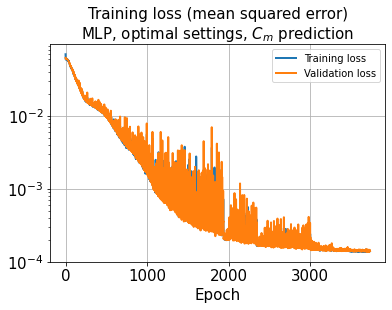

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

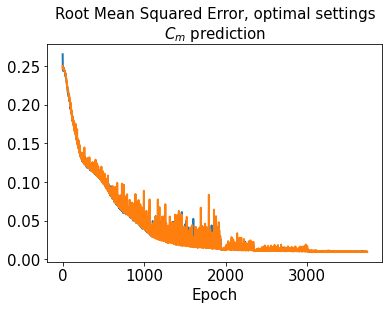

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

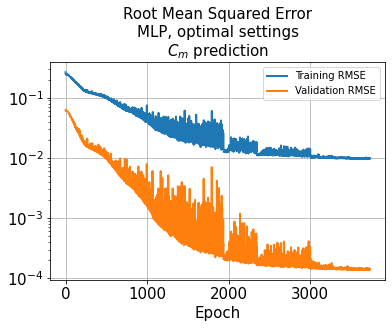

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

547/547 [==============================] - 2s 3ms/step - loss: 1.3715e-04 - rmse: 0.0097


In [37]:
val_results = model.evaluate(x_val, y_val)

157/157 [==============================] - 0s 3ms/step - loss: 1.3847e-04 - rmse: 0.0098


In [38]:
test_results = model.evaluate(x_test, y_test)

79/79 [==============================] - 0s 3ms/step - loss: 1.2754e-04 - rmse: 0.0092


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

79/79 [==============================] - 0s 1ms/step


In [40]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.021154491329705444
0.92188732018963


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.021141241411531227
0.925384631592096


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.019833796619880353
0.8669121346150755


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_5h_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

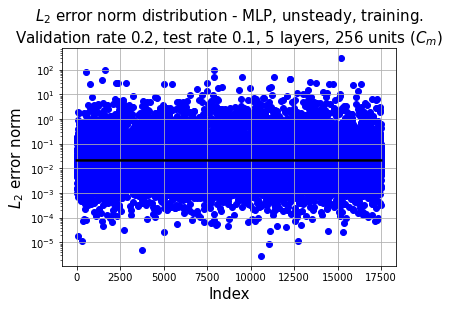

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

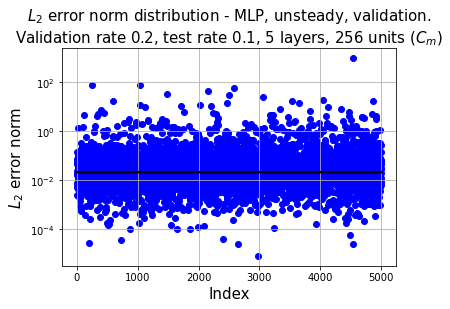

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

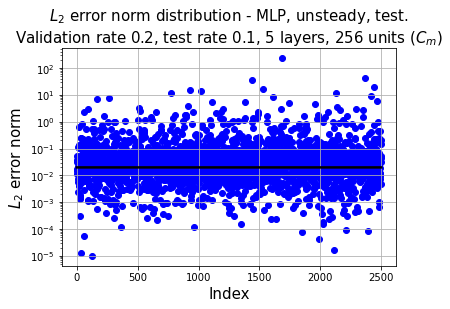

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict(x)

782/782 [==============================] - 1s 1ms/step


In [64]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [65]:
index_train.shape

(17500,)

In [66]:
max(predicted)

array([1.0175586], dtype=float32)

In [67]:
l2_error(denormalize(predicted), denormalize(y))

0.02923351769748084

In [68]:
l2_error(predicted, y)

0.021021430187813116

In [69]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [80]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [72]:
iTrain.shape

(17500, 1)

In [73]:
iVal.shape

(5001, 1)

In [74]:
iTest.shape

(2501, 1)

In [75]:
52499+15002+7501

75002

In [76]:
x += 10

L2 error of Cm: 0.0213


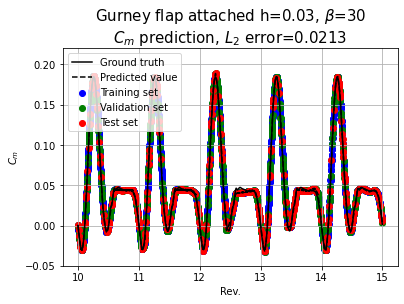

L2 error of Cm: 0.0187


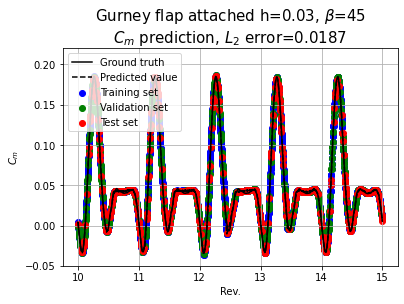

L2 error of Cm: 0.0249


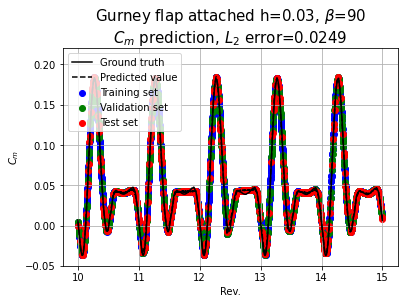

L2 error of Cm: 0.0195


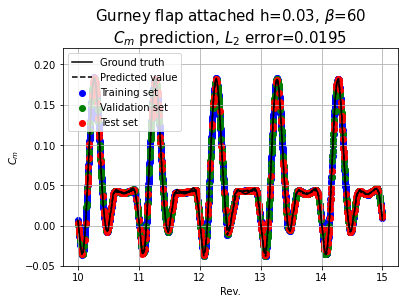

L2 error of Cm: 0.0202


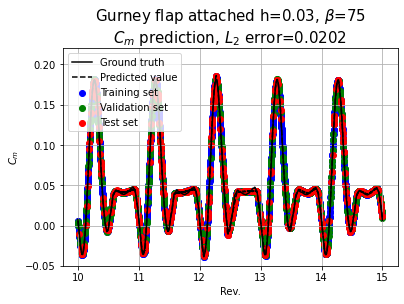

In [81]:
h = [0.03, 0.03, 0.03, 0.03, 0.03]
beta = [30, 45,90, 60, 75]
for i in range(0,5):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [82]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0213


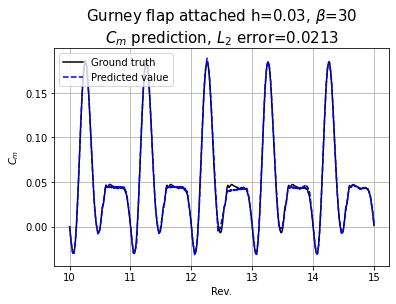

L2 error of Cm: 0.0187


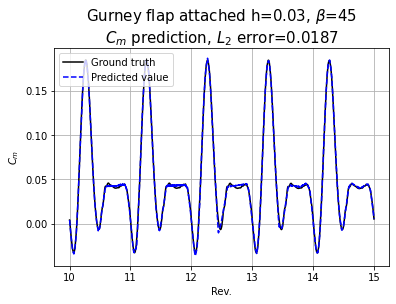

L2 error of Cm: 0.0249


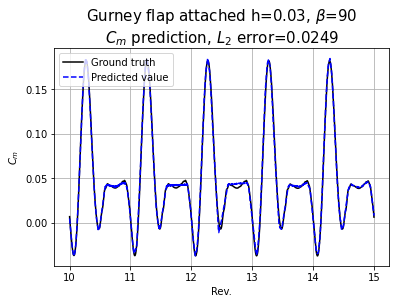

L2 error of Cm: 0.0195


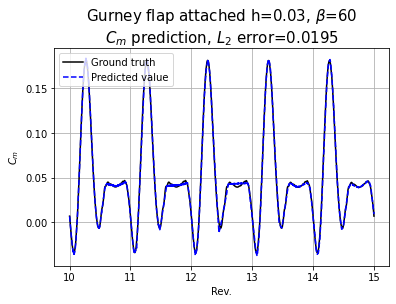

L2 error of Cm: 0.0202


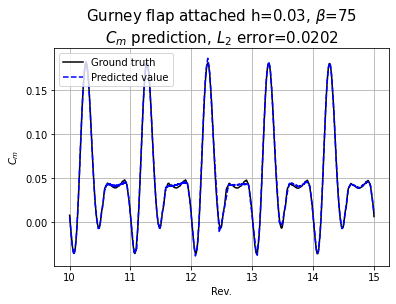

In [83]:
for i in range(0,5):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0213


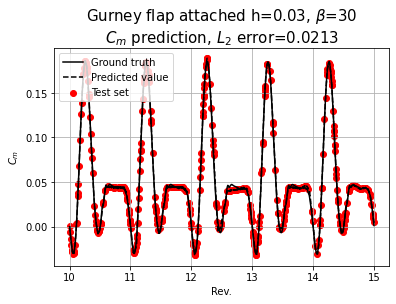

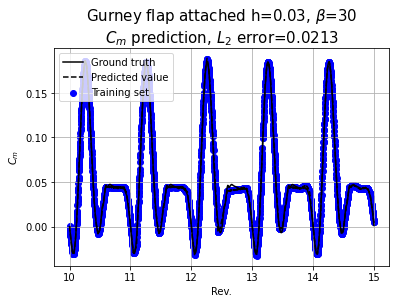

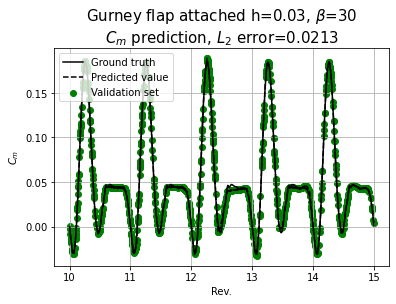

L2 error of Cm: 0.0187


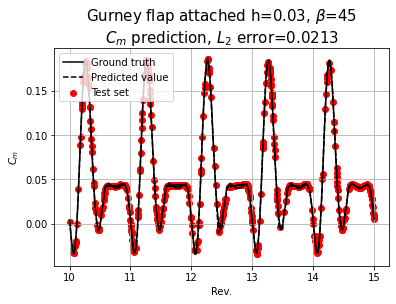

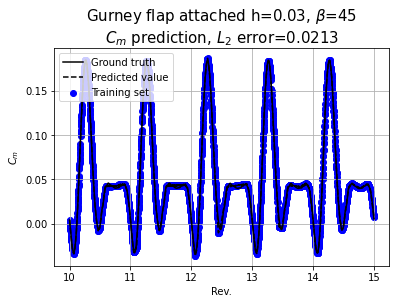

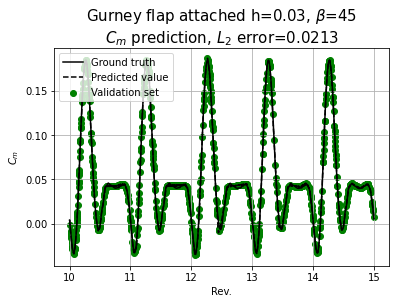

L2 error of Cm: 0.0249


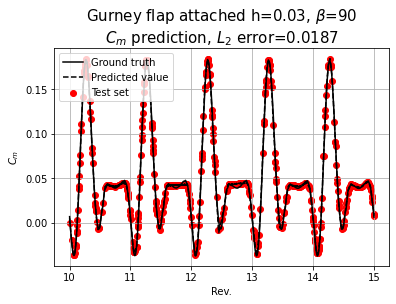

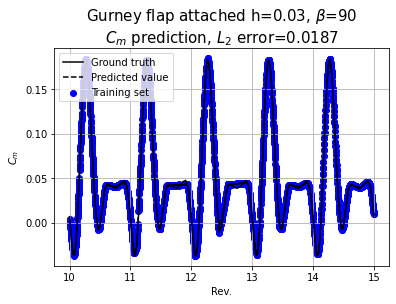

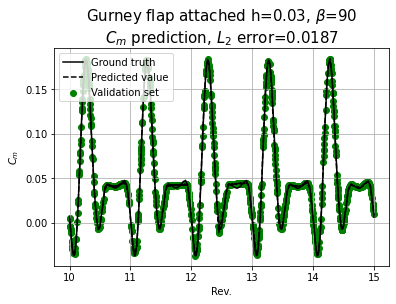

L2 error of Cm: 0.0195


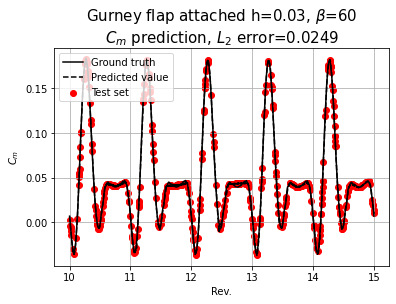

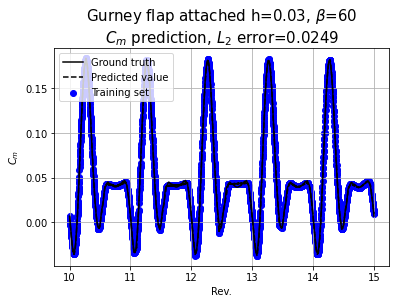

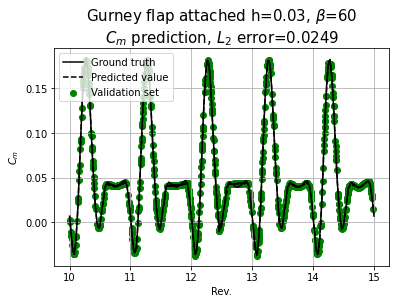

L2 error of Cm: 0.0202


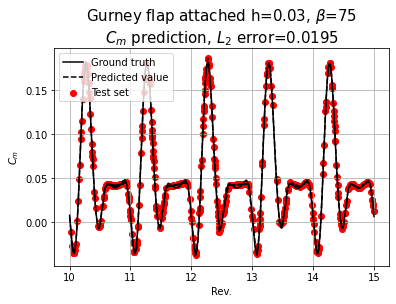

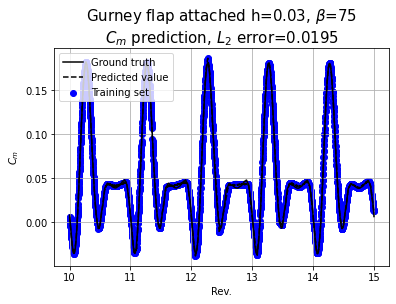

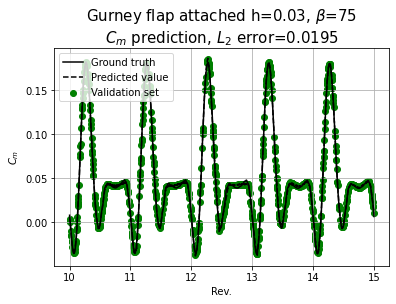

In [88]:
for i in range(0,5):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()